### COMS4060A/7056A: Assignment #1
**University of the Witwatersrand**  
**Lecturer:** Muhammad Nasir (<muhammad.nasir@wits.ac.za>)  
**Date:** September 2025

---

**Group Name:** *Visionaries*

**Members**

- Karabo Mohapeloa
- Taruna Naidoo - 2546838
- Humani Nenzhelele - 1602841
- Daniel Ngobe - 2556833


## 1. Data Cleaning

This dataset relies heavily on user input from around the world. Expect issues such as:
- **`date fueled`** sometimes containing free-text descriptions instead of dates.
- **Numeric fields** (e.g., `gallons`, `miles`, `odometer`) written with thousands separators (e.g., `1,523.50`) that must be cleaned before conversion.
- **Cost fields** (`cost per gallon`, `total spent`) that include currency symbols (e.g., `R500`, `$500`) across many currencies.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import math
import scipy.stats as stats
import warnings 
import matplotlib
import matplotlib.cm as cm
sns.set(rc={'figure.figsize':(12,6)})
warnings.simplefilter(action='ignore', category= FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

%matplotlib inline

import missingno

In [2]:
df = pd.read_csv(
    "logbook_assignment1.csv",
    low_memory=False  # avoids the warning, but doesn't fix dirty values
)

df.shape

(1174870, 9)

In [3]:
df.sample(5)

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
405754,Jan 12 2014,Jan 12 2014,NaN,5.608,€6.24,€35.01,18.1,101.3,https://www.somewebsite.com/suzuki/jimny/2006/...
812645,NaN,Jan 12 2019,NaN,10.172,CA$4.08,CA$41.51,25.5,259.0,https://www.somewebsite.com/volkswagen/jetta_c...
161435,Aug 17 2020,Aug 17 2020,"135,187",15.915,$1.829,$29.11,18.8,NaN,https://www.somewebsite.com/ford/crown_victori...
846275,Jul 16 2017,Jul 16 2017,"285,259",11.144,$2.699,$30.08,15.5,NaN,https://www.somewebsite.com/volkswagen/eurovan...
955947,Registration,Feb 23 2021,"118,580",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/lexus/es300/2001/4...


### 1.1 Date Fields

#### 1. Identify the **percentage of `date_fueled` entries that are not valid dates**. 

In [4]:
valid_dates = pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce').notna()
perc_invalid_dates = sum(valid_dates == False)/len(df)*100
print('Percentage of date_fueled entries not proper dates:', perc_invalid_dates, '%')
print('Number of invalid date_fueled entries:', sum(valid_dates == False))

Percentage of date_fueled entries not proper dates: 11.678738924306518 %
Number of invalid date_fueled entries: 137210


#### 2. Where `date_fueled` is invalid but **`date_captured` is valid**, **fill** `date_fueled` with `date_captured` as a proxy. 

In [6]:
valid_ = pd.to_datetime(df['date_captured'], format='%b %d %Y', errors='coerce').notna()
val_cap = sum(valid_ == True)/len(df)*100
print('Valid dates_captured:', val_cap, "%")
df['date_fueled_proxy'] = pd.to_datetime(np.where((pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce').notna() == False),df['date_captured'],df['date_fueled']), format='%b %d %Y', errors='coerce')

Valid dates_captured: 100.0 %


#### 3. **Convert** `date fueled` to a date type; set any invalid entries to **NaT**.

In [7]:
df['date_fueled'] = pd.to_datetime(df['date_fueled'], format='%b %d %Y', errors='coerce')
df['date_captured'] = pd.to_datetime(df['date_captured'], format='%b %d %Y', errors='coerce')

print(df.dtypes)
df.sample(5)

date_fueled          datetime64[ns]
date_captured        datetime64[ns]
odometer                     object
gallons                      object
cost_per_gallon              object
total_spent                  object
mpg                          object
miles                        object
user_url                     object
date_fueled_proxy    datetime64[ns]
dtype: object


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_proxy
834872,2022-01-31,2022-01-31,"178,680",18.355,Nkr67.04,"Nkr1,230.49",19.3,NaN,https://www.somewebsite.com/peugeot/807/2004/6...,2022-01-31
444463,2021-04-21,2021-04-21,NaN,19.490,$2.766,$53.91,14.9,294.3,https://www.somewebsite.com/lexus/gx470/2006/1...,2021-04-21
326417,2017-10-09,2017-10-09,"44,728",11.159,$2.509,$28.00,30.9,NaN,https://www.somewebsite.com/kia/forte5/2015/67...,2017-10-09
670467,2021-05-22,2021-05-22,"168,502",13.632,$2.979,$40.61,44.0,NaN,https://www.somewebsite.com/volkswagen/golf/20...,2021-05-22
969933,2016-08-30,2016-08-30,"30,869",6.734,£4.24,£28.53,26.9,NaN,https://www.somewebsite.com/mazda/mx-5_miata/2...,2016-08-30


#### 4. **Remove dates** that are in the **future** or **earlier than 2005**.

In [9]:
print("Before removing invalid dates, the shape of the dataframe is:", df.shape)

df = df.loc[(df['date_fueled_proxy'] >= '2005-01-01') & (df['date_fueled_proxy'] <= datetime.datetime.now())]

print("After removing invalid dates, the shape of the dataframe is:", df.shape)

Before removing invalid dates, the shape of the dataframe is: (1174300, 10)
After removing invalid dates, the shape of the dataframe is: (1174300, 10)



#### 5. **Plot the distribution** of fueling dates and **comment** on the results. 

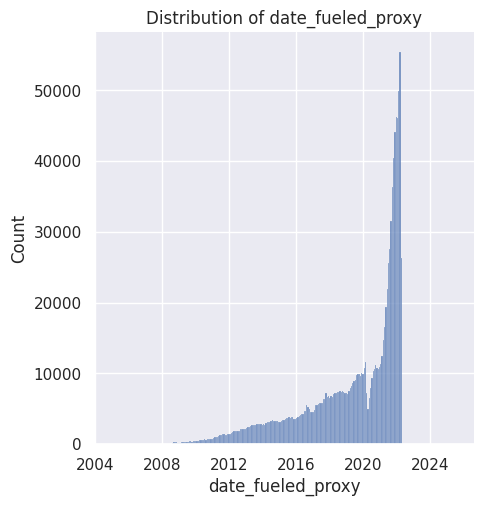

In [10]:
sns.displot(df, x="date_fueled_proxy")
plt.title("Distribution of date_fueled_proxy")
plt.show()

The distribution of fueling dates shows a gradual increase from 2005, suggesting that more users were logging fuel data over time, likely due to the platform gaining popularity. The sudden dip around 2020 could correspond to the global COVID-19 pandemic, when lockdowns and travel restrictions sharply reduced vehicle usage. The subsequent rapid increase may reflect a rebound as restrictions eased and more users returned where acustomed to digital spaces because of working from home.

### 1.2 Numeric Fields

#### 1. Identify what percentage of `gallons`, `miles`, and `odometer` entries are missing

In [11]:
percent_nulls = (df[['gallons', 'miles', 'odometer', 'mpg']].isna().sum()/len(df))*100
print(percent_nulls.astype(str) + ' %')

gallons      6.316188367538107 %
miles        87.55369156092992 %
odometer    12.691560929915694 %
mpg          6.316188367538107 %
dtype: object


#### 2. The `miles`, `gallons` and `mpg` columns are interdependent. If one is missing, the other two can be used to calculate it.

In [13]:
df['miles'] = df['miles'].replace(',', '', regex=True).astype(float)
df['odometer'] = df['odometer'].replace(',', '', regex=True).astype(float)
df['gallons'] = df['gallons'].replace(',', '', regex=True).astype(float)
df['mpg'] = df['mpg'].replace(',', '', regex=True).astype(float)

#The formula to calculate mpg: Miles driven ÷ gallons used to refill the tank
df['mpg'] = df['mpg'].fillna(df['miles']/df['gallons'])

#Formula for Miles: mpg*gallons
df['miles'] = df['miles'].fillna(df['mpg']*df['gallons'])

#Formula for gallons: miles/mpg
df['gallons'] = df['gallons'].fillna(df['miles']/df['mpg'])

print("After cleaning, the missing values are: \n")
percent_nulls = (df[['gallons', 'miles', 'mpg']].isna().sum()/len(df))*100
print(percent_nulls.astype(str) + ' %')


After cleaning, the missing values are: 

gallons    6.316188367538107 %
miles      6.316188367538107 %
mpg        6.316188367538107 %
dtype: object


#### 3. The values will be read in as objects (or strings) by Pandas. Convert these values to float (note the point above about commas in the value).

In [14]:
df.dtypes

date_fueled          datetime64[ns]
date_captured        datetime64[ns]
odometer                    float64
gallons                     float64
cost_per_gallon              object
total_spent                  object
mpg                         float64
miles                       float64
user_url                     object
date_fueled_proxy    datetime64[ns]
dtype: object

#### 4. Plot the distributions and comment on the distributions

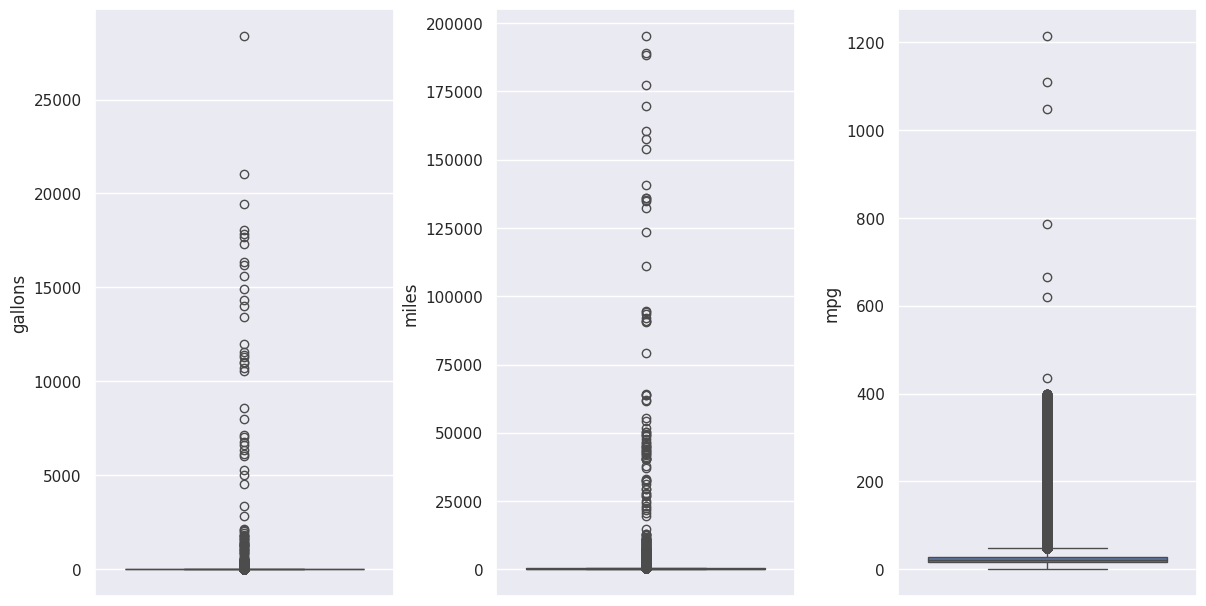

In [15]:
data_m_g_mpg = df[['gallons', 'miles', 'mpg']]
fig, axs = plt.subplots(ncols=3, nrows=1)
index = 0
axs = axs.flatten()
for k,v in data_m_g_mpg.items():
    sns.boxplot(y=k, data=data_m_g_mpg, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

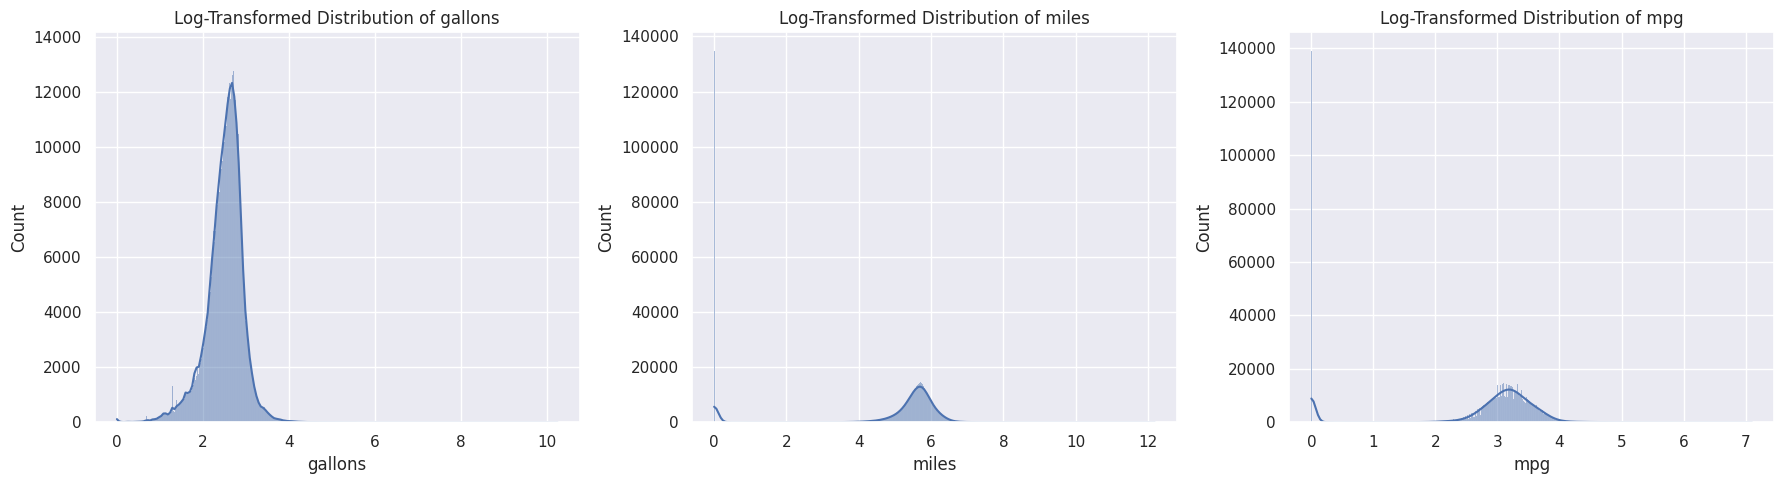

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, x in zip(axes, ['gallons', 'miles', 'mpg']):
    sns.histplot(np.log1p(df[x]), kde=True, ax=ax)
    ax.set_title(f'Log-Transformed Distribution of {x}')

plt.tight_layout()
plt.show()

 <center> REMEMBER TO COMMENT HERE ⁉️ </center>

5. Compute the statistical description of the columns: mean, standard deviation, max, min, most frequent, and quartiles. Do these results make
sense? [3]

In [17]:
# suppressing scientific notation when printing float values
pd.options.display.float_format = '{}'.format

df[['miles', 'gallons', 'mpg']].describe()

,miles,gallons,mpg
count,1100129.0,1100129.0,1100129.0
mean,269.4538013011202,12.797430474971572,22.163024699830657
std,725.7634370035393,74.48279111437778,15.744350144205045
min,0.0,0.0,0.0
25%,181.4,8.99,15.6
50%,267.0486,11.954,21.8
75%,342.7641,14.939,28.5
max,195321.2,28380.0,1214.3


These descriptions show that the mean for gallons is approximately 13 which makes sense, as I have mentioned that an average sized tank can hold between 12 to 18 gallons of fuel. There are clearly some extremes which do not make sense in this column. As we can see the maximum gallons is 28380, which seems highly unlikely for a car to be filled with that many gallons of fuel.

For mpg, the values make sense in relation to the values of miles and gallons. In reality, an average car (based in USA) gets an average of 25mpg. The average mpg here is 22 which is very close to 25, thus it makes sense in this aspect as well.

For miles, the average is 269 miles. This makes sense in relation to the average of 22mpg. If a car rides 269 miles based on 22mpg, on average they would consume 12-13 gallons of fuel. The maximum miles driven is 195321 miles. In relation to the extreme max value of gallons, this makes sense.

## 2 Feature engineering

#### 1. Create a new column with the currency. (Something to keep in mind is that the Swiss Franc has a period in the abbreviation).

In [18]:
df['currency'] = df['total_spent'].astype(str).str.extract(r'([^\d.,]+)')

#### 2. Create a new column containing the float value of the total spend and the cost per gallon. (Swiss Franc comment as above).

In [19]:
df["total_spent_float"] = df["total_spent"].str.extract(r"(\d*\.?\d+)", expand=True).astype(float)
df['cpg_float'] = df['cost_per_gallon'].str.extract(r"(\d*\.?\d+)", expand=True).astype(float)

#### 3. Car make, model, year, User ID: use the url (the last value in the URL is the user ID)


In [20]:
print(df['user_url'].head(10))

df['car_make'] = df['user_url'].str.split('/').str[3]
df['car_model'] = df['user_url'].str.split('/').str[4]
df['car_year'] = pd.to_numeric(df['user_url'].str.split('/').str[-2], errors='coerce')
df['user_id'] = df['user_url'].str.split('/').str[-1]


df.loc[(df['car_year'] < 1800) | (df['car_year'] > datetime.datetime.now().year), 'car_year'] = np.nan


0    https://www.somewebsite.com/suzuki/swift/2015/...
1       https://www.somewebsite.com/bmw/x3/2009/461150
2    https://www.somewebsite.com/mercedes-benz/e300...
3     https://www.somewebsite.com/bmw/320d/2010/247233
4    https://www.somewebsite.com/honda/passport/201...
5    https://www.somewebsite.com/volkswagen/passat/...
6    https://www.somewebsite.com/mazda/3_sport/2010...
7    https://www.somewebsite.com/subaru/forester/20...
8     https://www.somewebsite.com/kianival/2009/789684
9    https://www.somewebsite.com/lexus/rx350/2012/8...
Name: user_url, dtype: object


#### The data is given in imperial units, and in SA, we use proper measurement standards.

1. litres filled: use the gallons - consider whether to use UK or US gallons.

In [26]:
# Formula to convert to litres from gallons: gallons*3.785411784
# US Standard: 1 US liquid gallon = 3,78541 Liter
# UK Standard: 1 UK Gallon  = 4.54609 Litres

df['litres_filled'] = df['gallons']*3.785411784

The US gallons of 1 US liquid gallon = 3,78541 Litre was used. Using US gallons aligns with international standards, ensures consistency within the dataset and prevents large conversion errors. This makes the results directly comparable with common fuel economy measures.

2. km driven: use the miles driven to compute this

In [27]:
# Formula to convert from miles to km: miles*1.60934
df['km_driven'] = df['miles']*1.60934


3. litres per 100km: use the two new features to calculate this.

In [28]:
# Formula for litres per 100km: (litres_filled/km_driven)*100
df['litres_per_100km'] = (df['litres_filled']/df['km_driven'])*100

The l/100km is inversly proportionate

In [30]:
new_order = [
    'user_id', 'date_fueled_proxy', 'currency', 'total_spent_float', 'cpg_float', 
    'car_make', 'car_model', 'car_year', 'km_driven',
    'litres_filled', 'litres_per_100km',
    'cost_per_gallon', 'total_spent',  
    'date_fueled', 'date_captured', 'miles', 'odometer', 'gallons', 'mpg',
    'user_url',
]

df = df[new_order]
df.sample(5)


,user_id,date_fueled_proxy,currency,total_spent_float,cpg_float,car_make,car_model,car_year,km_driven,litres_filled,litres_per_100km,cost_per_gallon,total_spent,date_fueled,date_captured,miles,odometer,gallons,mpg,user_url
980941,1062035,2021-03-15,$,64.18,2.899,ford,e-350_super_duty,2004.0,502.34872177200003,83.801446074192,16.681926805464588,$2.899,$64.18,2021-03-15,2021-03-15,312.1458,250086.0,22.138,14.1,https://www.somewebsite.com/ford/e-350_super_d...
5841,742937,2018-04-12,Rs,1.0,262.18,ford,ecosport,2017.0,389.39832041000005,22.50427305588,5.779242455947191,Rs262.18,"Rs1,558.77",2018-04-12,2018-06-04,241.96150000000003,2180.0,5.945,40.7,https://www.somewebsite.com/ford/ecosport/2017...
924730,495070,2019-12-20,$,24.0,2.269,lexus,ls460,2008.0,357.42797664,40.034515027584,11.200722283669082,$2.269,$24.00,2019-12-20,2019-12-20,222.096,109047.0,10.576,21.0,https://www.somewebsite.com/lexus/ls460/2008/4...
361991,1085369,2021-09-07,$,150.54,21.918,toyota,yaris,2021.0,306.166635224,25.998208132512,8.4915223089188,$21.918,$150.54,2021-09-07,2021-09-24,190.24360000000001,1426.0,6.868,27.7,https://www.somewebsite.com/toyota/yaris/2021/...
166902,583269,2017-03-26,$,28.97,2.409,volkswagen,cabrio,1999.0,387.01408319999996,45.515791290816,11.760758397852536,$2.409,$28.97,NaT,2017-03-26,240.48,159278.0,12.024,20.0,https://www.somewebsite.com/volkswagen/cabrio/...


## 3. Vehicle Exploration

#### 1. Plot the number of unique users per country (remember, we proxy this by currency).

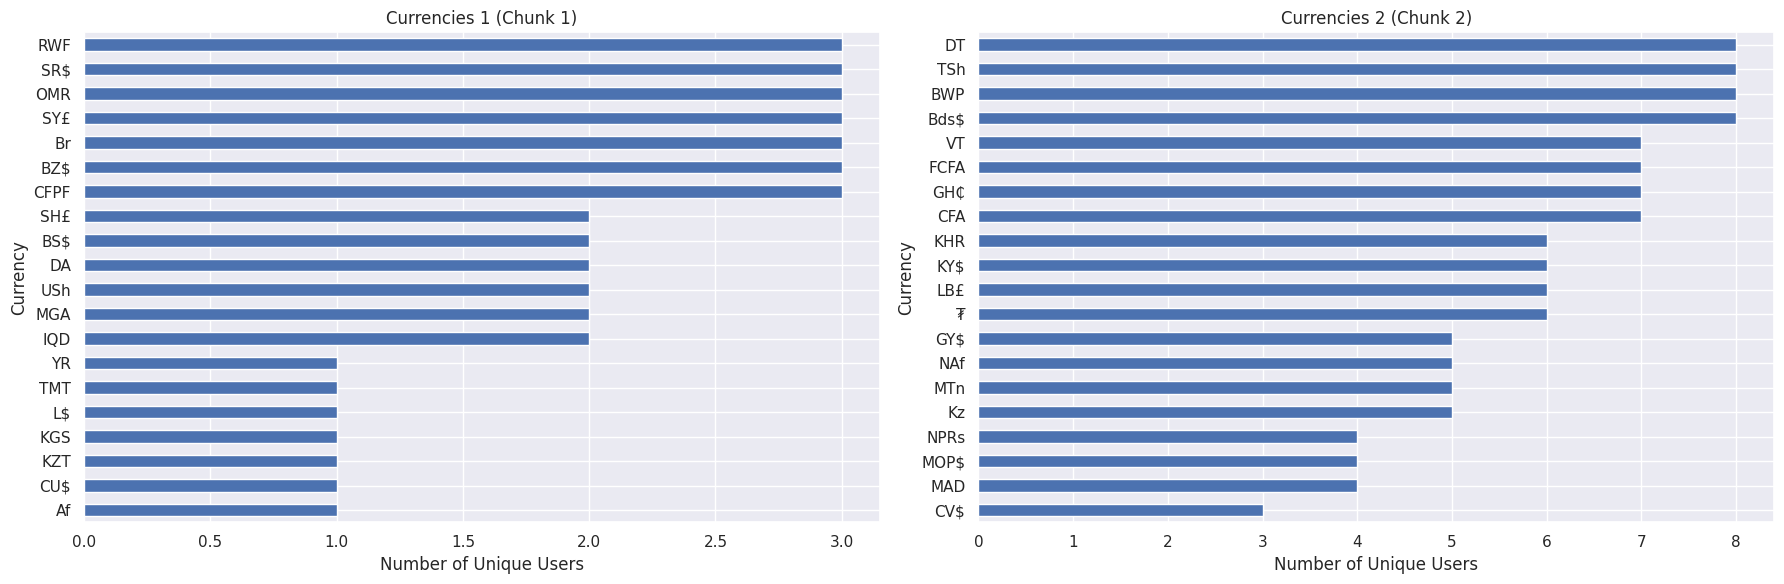

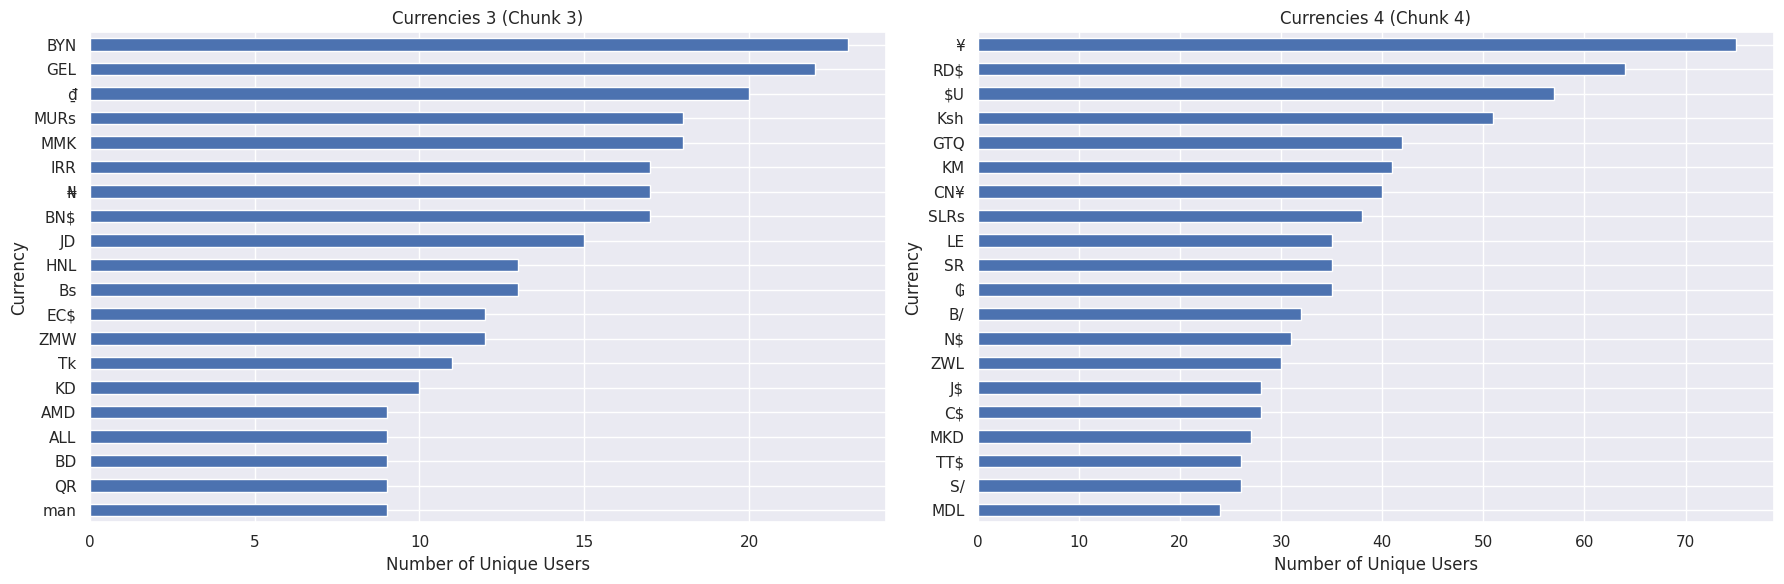

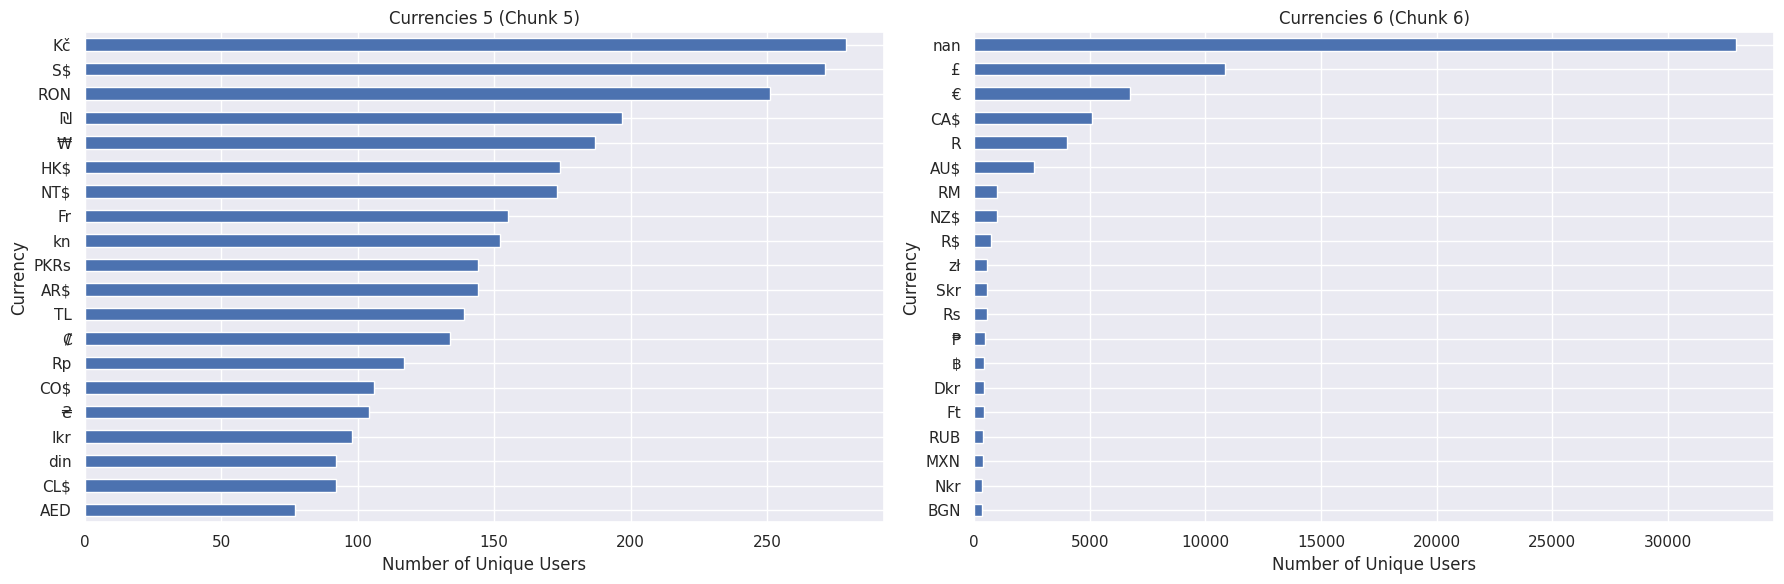

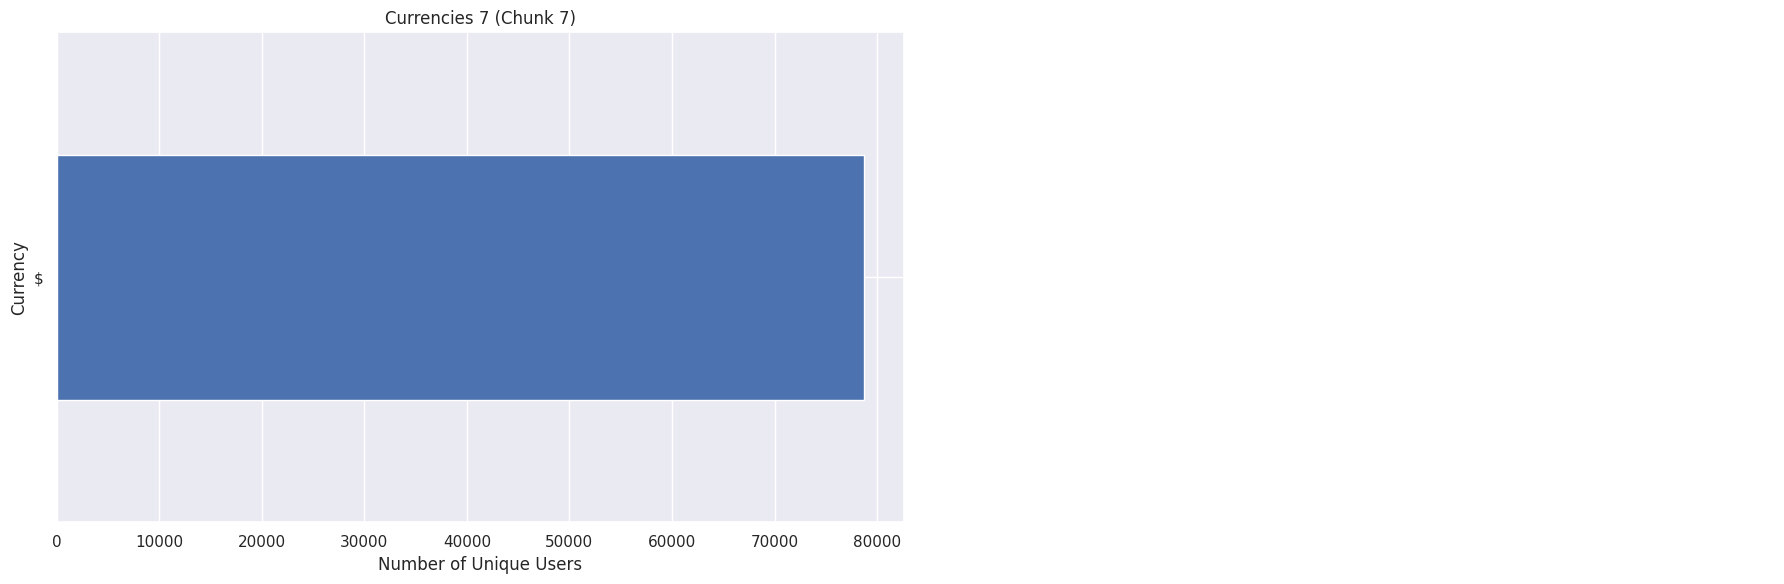

In [31]:
import matplotlib.pyplot as plt
import numpy as np

unique_users = df.groupby('currency')['user_id'].nunique().sort_values()

chunk_size = 20  # currencies per plot
chunks = [unique_users.iloc[i:i+chunk_size] for i in range(0, len(unique_users), chunk_size)]

# Plot 2 plots per row
for i in range(0, len(chunks), 2):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for j in range(2):
        if i+j < len(chunks):
            chunks[i+j].plot(kind='barh', ax=axes[j])
            axes[j].set_xlabel('Number of Unique Users')
            axes[j].set_ylabel('Currency')
            axes[j].set_title(f'Currencies {i+j+1} (Chunk {i+j+1})')
        else:
            axes[j].axis('off')  # turn off empty subplot

    plt.tight_layout()
    plt.show()


#### 2. Look at the popularity of the app: plot the number of unique users per day.

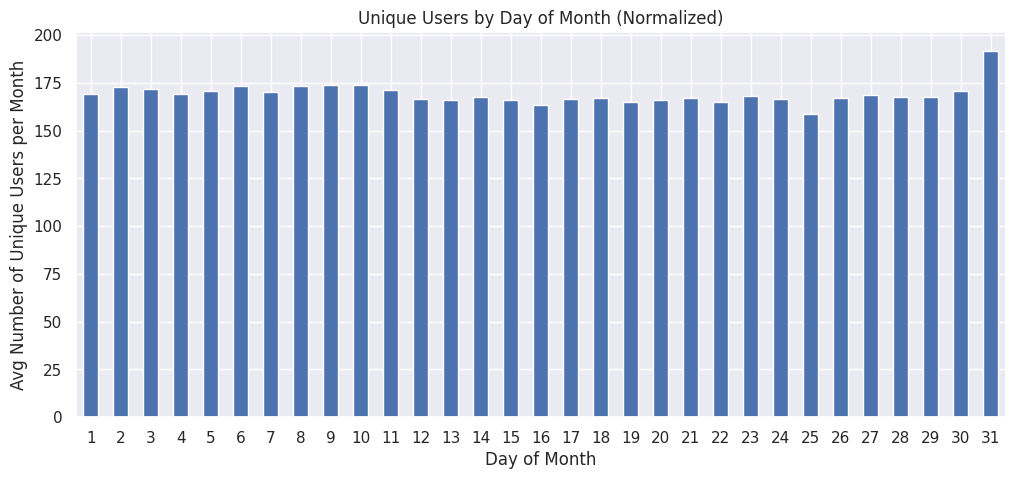

In [33]:
# Count unique users per day of month
users_per_day_of_month = df.groupby(df['date_captured'].dt.day)['user_id'].nunique()

# Count how many months have each day
days = df['date_captured'].dt.day
months = df['date_captured'].dt.month
years = df['date_captured'].dt.year
month_day_counts = df.groupby([years, months])['date_captured'].apply(lambda x: x.dt.day.unique())
day_month_counts = pd.Series([day for days_in_month in month_day_counts for day in days_in_month]).value_counts().sort_index()

# Normalize users per day by number of months with that day
normalized_users = users_per_day_of_month / day_month_counts

# Plot
plt.figure(figsize=(12,5))
normalized_users.plot(kind='bar')
plt.xlabel('Day of Month')
plt.ylabel('Avg Number of Unique Users per Month')
plt.title('Unique Users by Day of Month (Normalized)')
plt.xticks(rotation=0)
plt.show()

It was found that users were more active on the 31st of the month. 
    This is likely due to the average of the 31st day of the 7 months that contain 31 days being higher compared to the other days. 
    The number of unique users per day is generally lower for the 31st and the highest from the 8th to the 10th.

<span style="color:gold;font-weight:bold;">Improved above graph for fairness on days like 31st</span>

#### 3. Look at the distribution of age of the vehicles per country - look at the year of the vehicle. Remember to look at the date it was refuelled, not the current date.

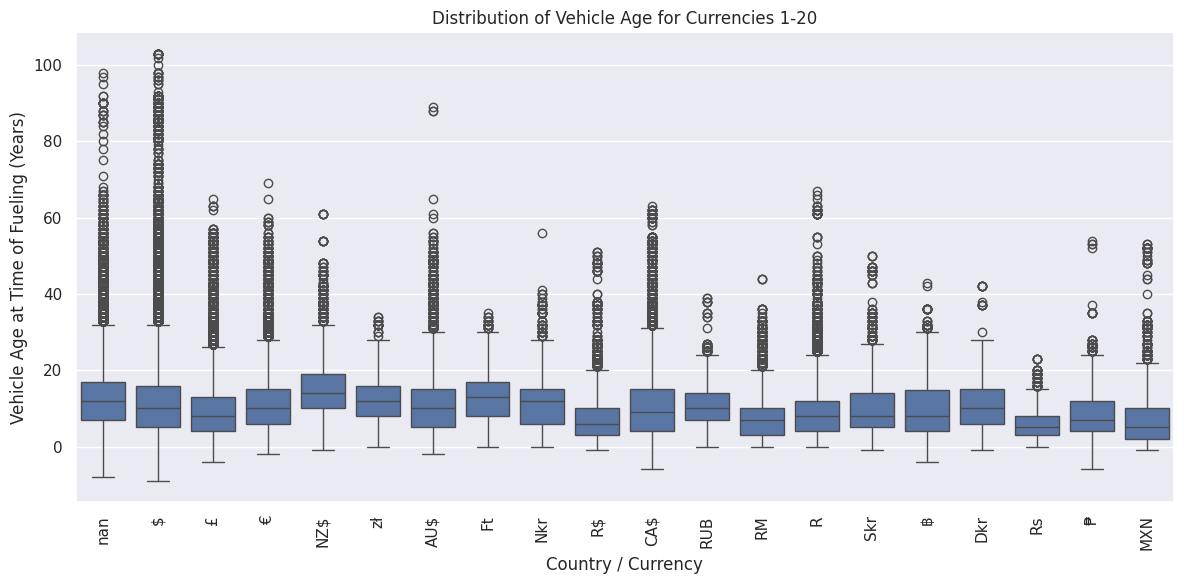

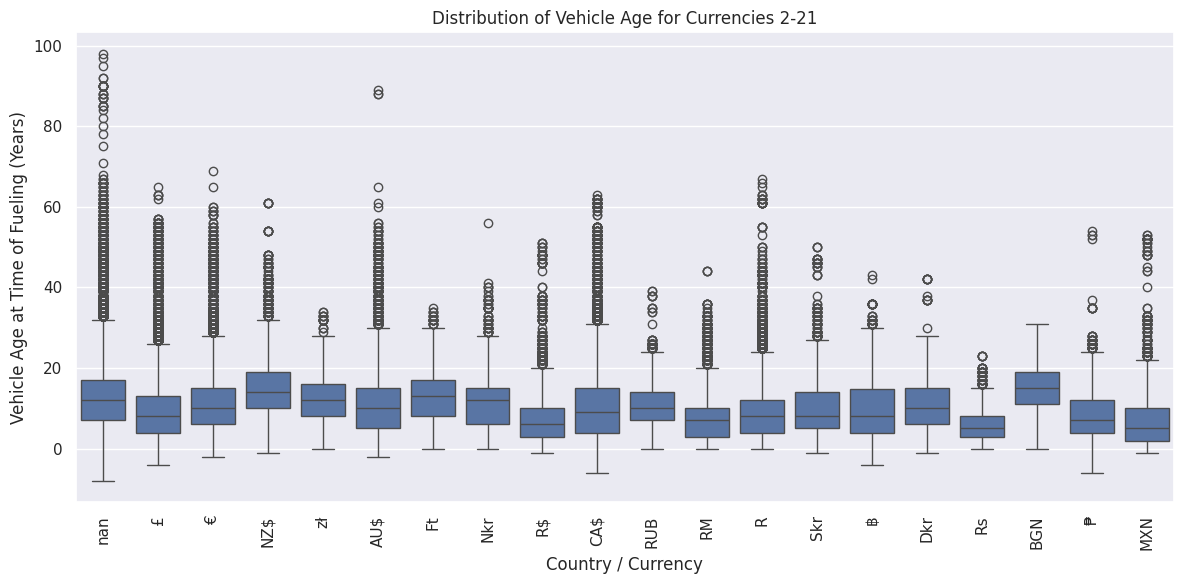

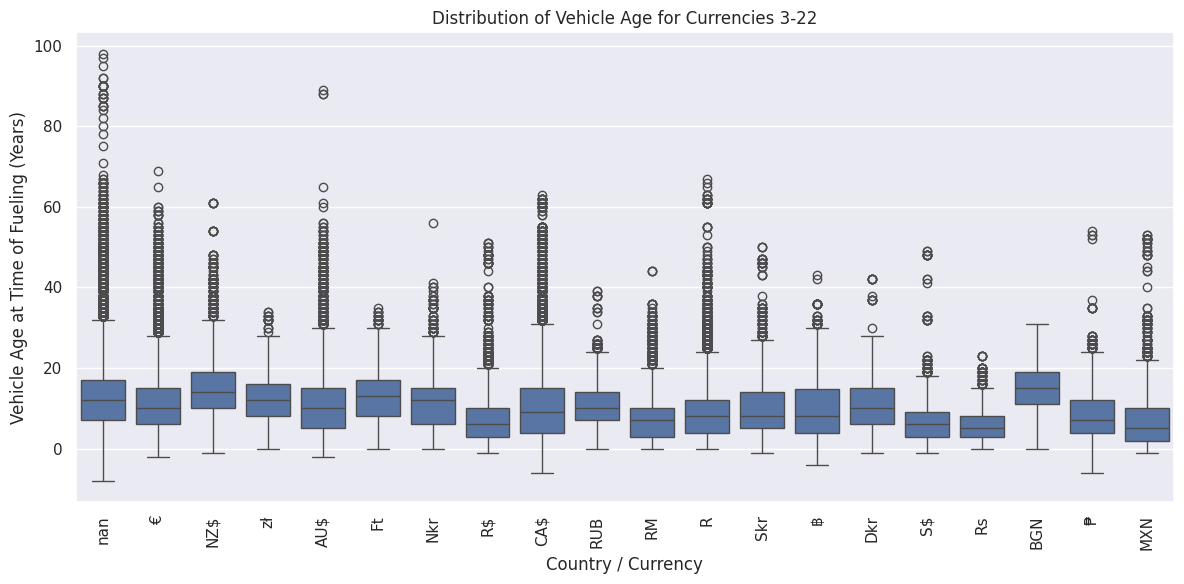

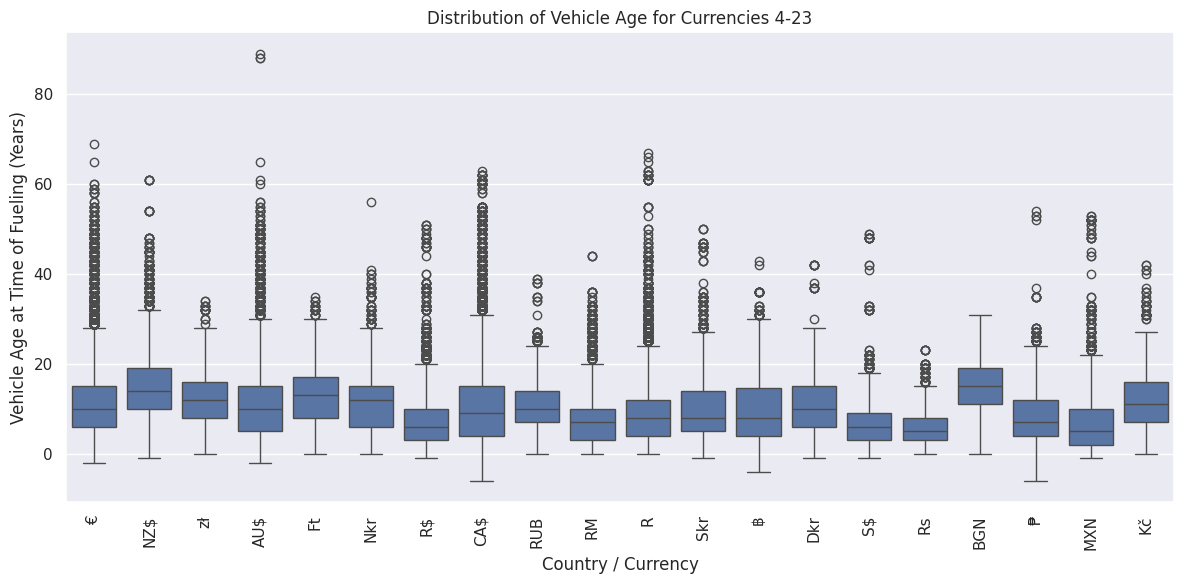

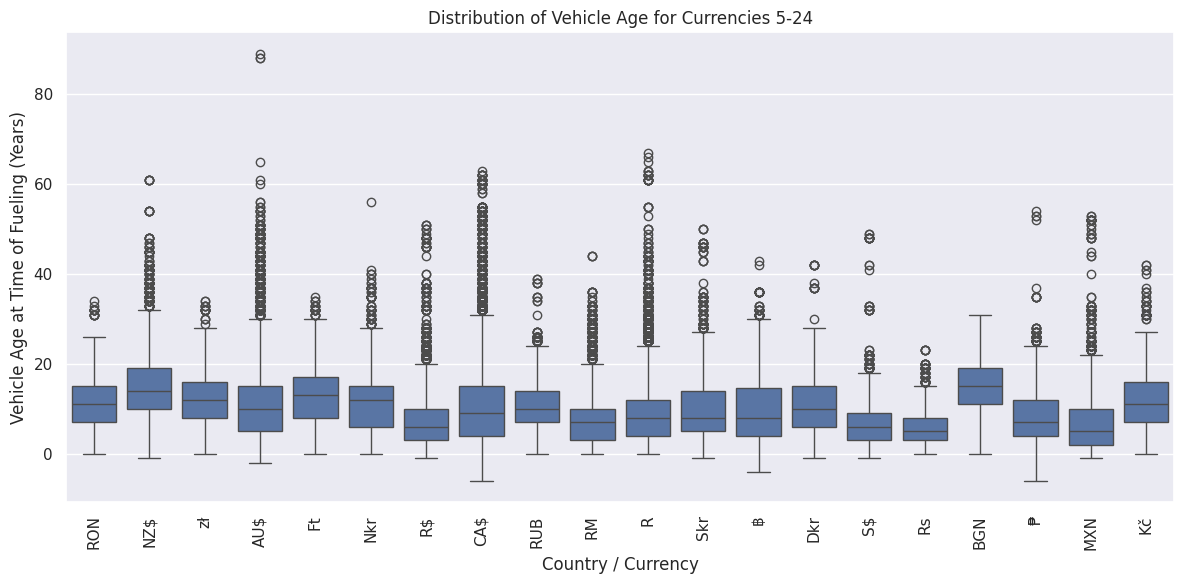

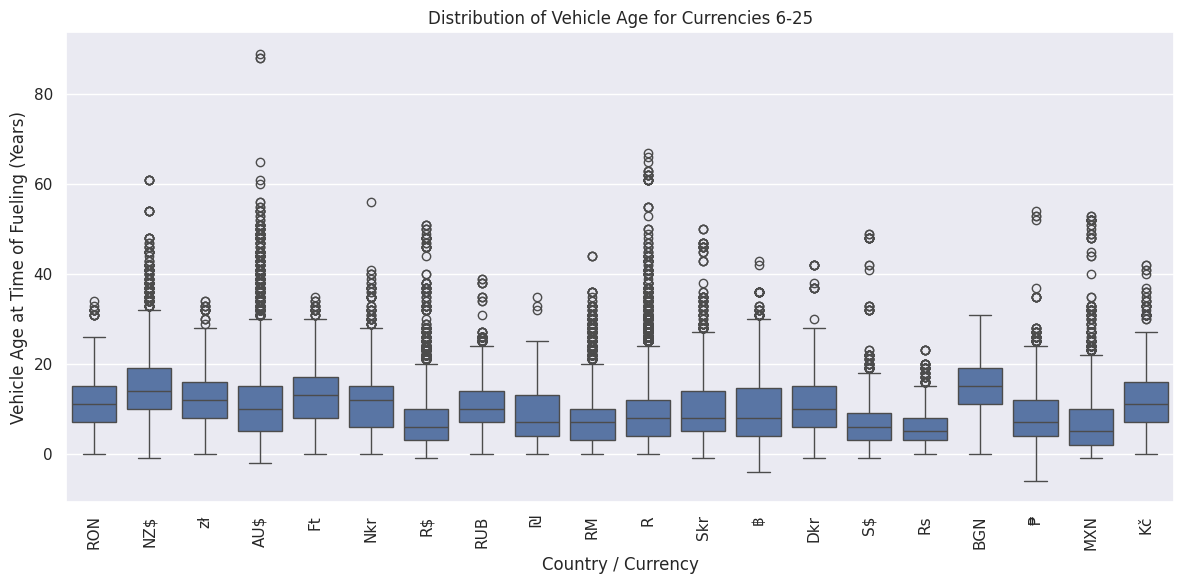

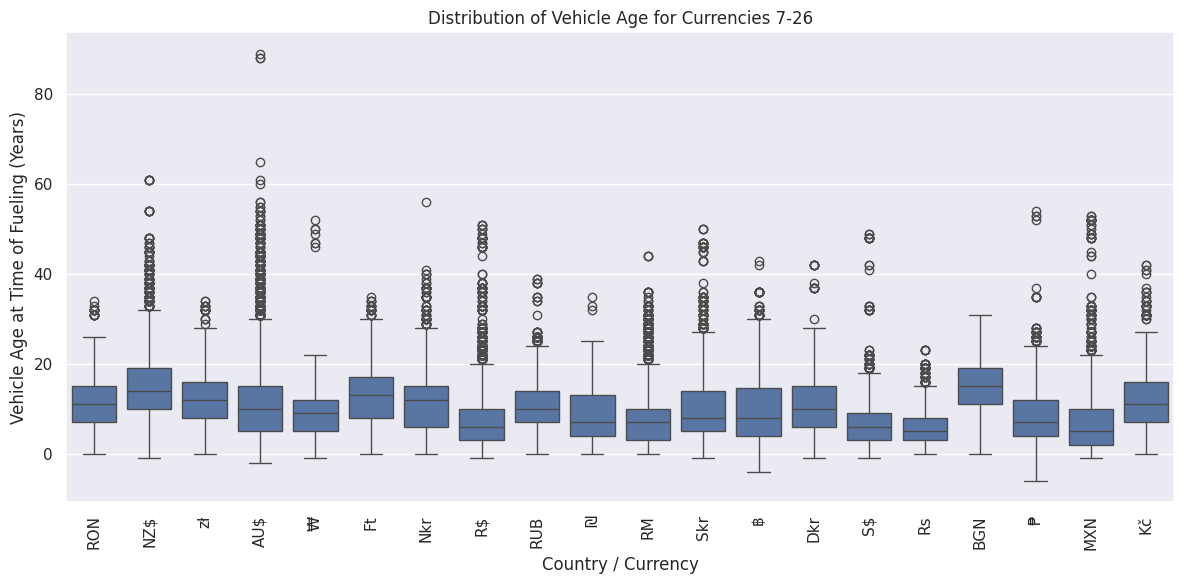

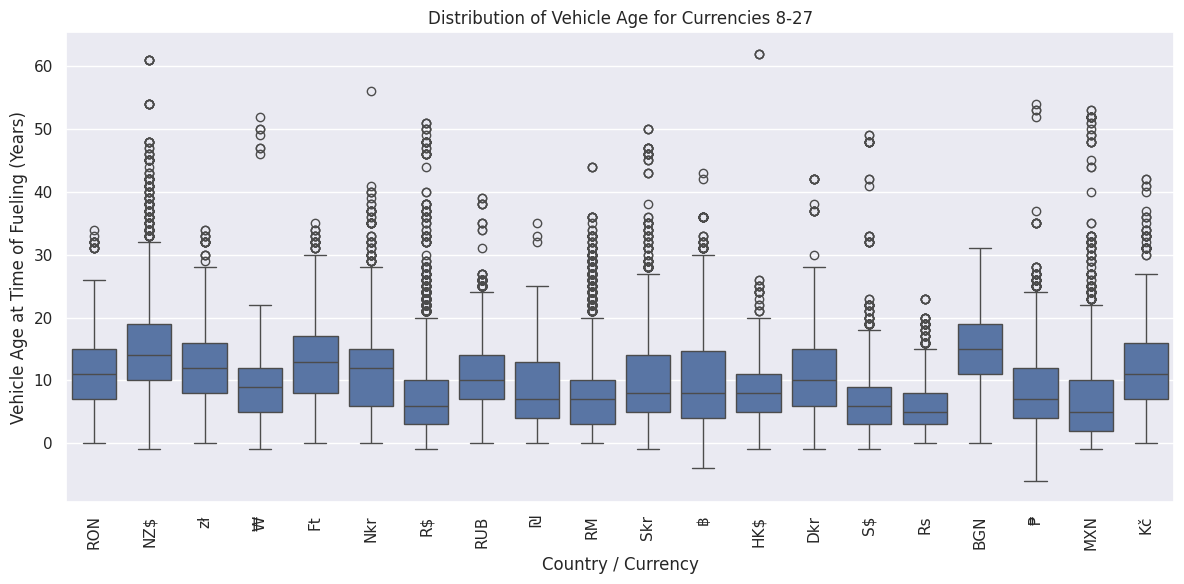

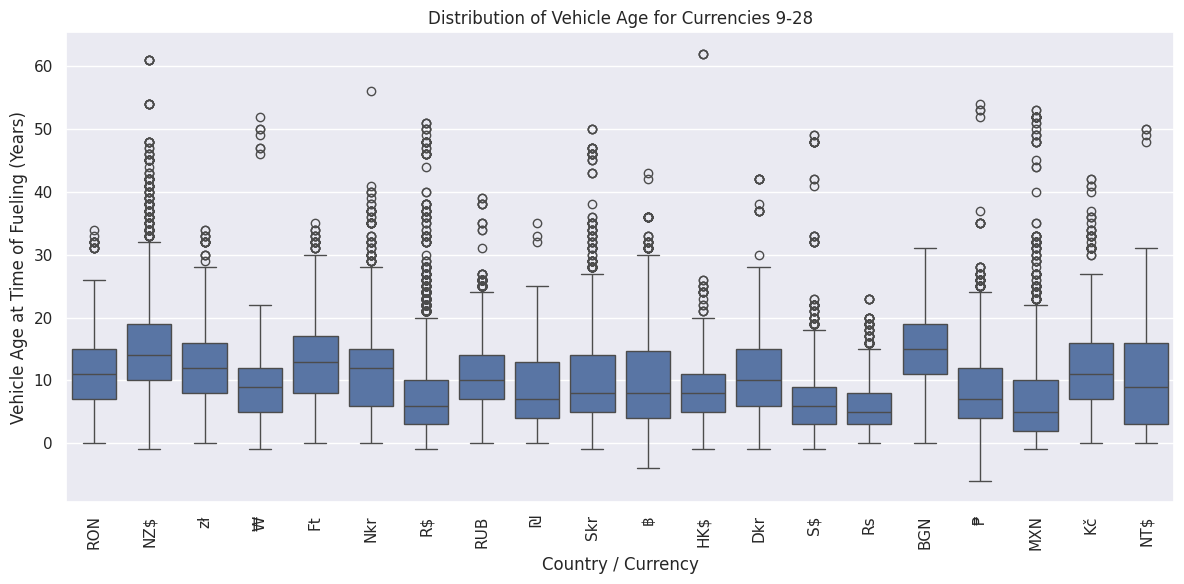

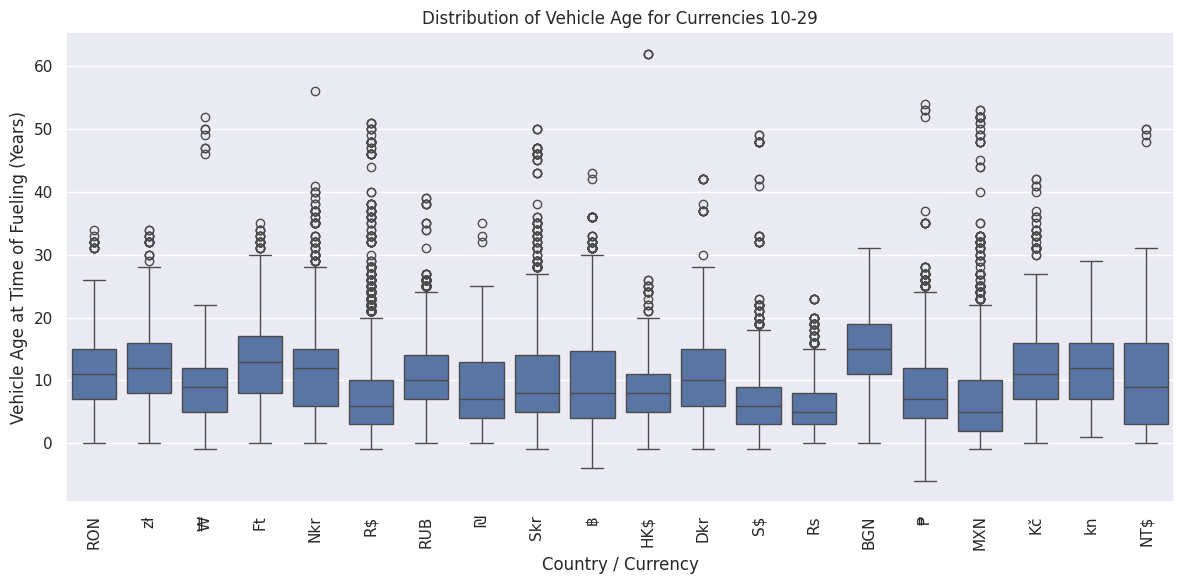

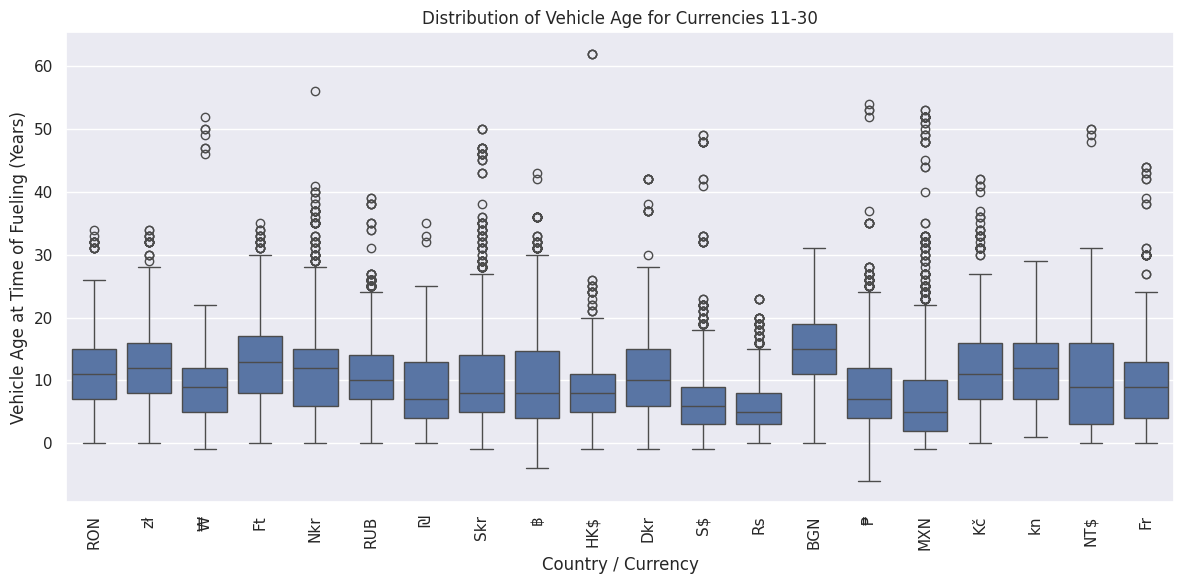

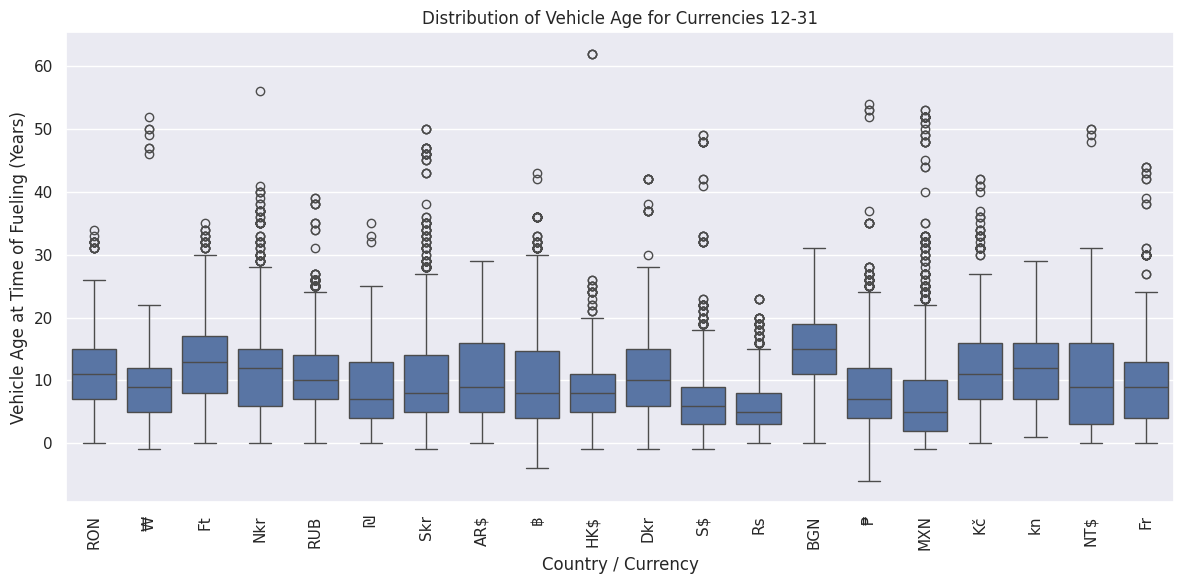

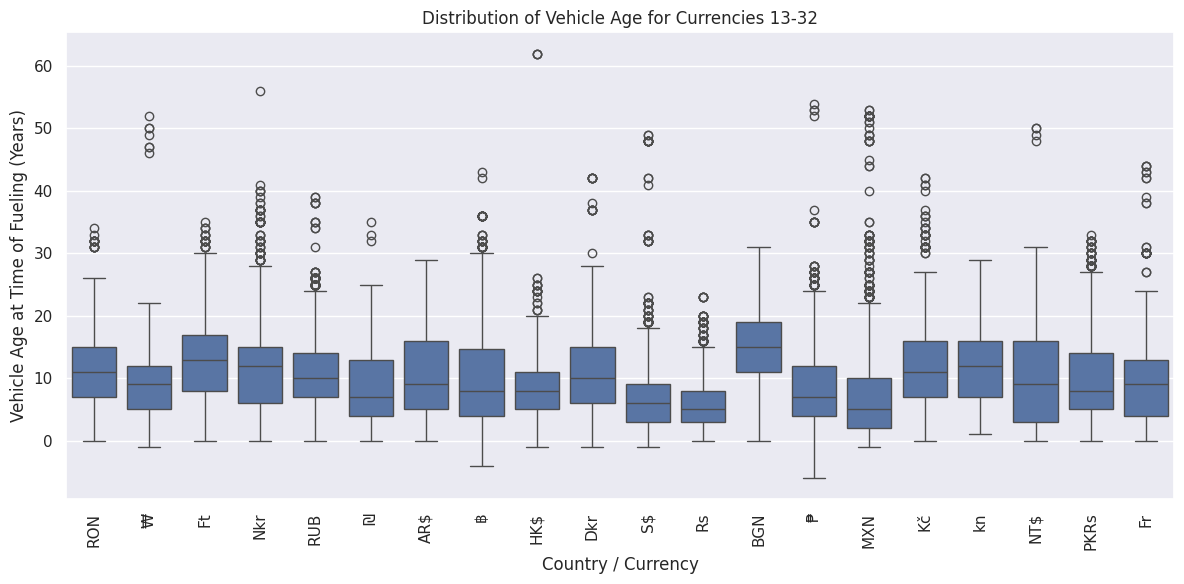

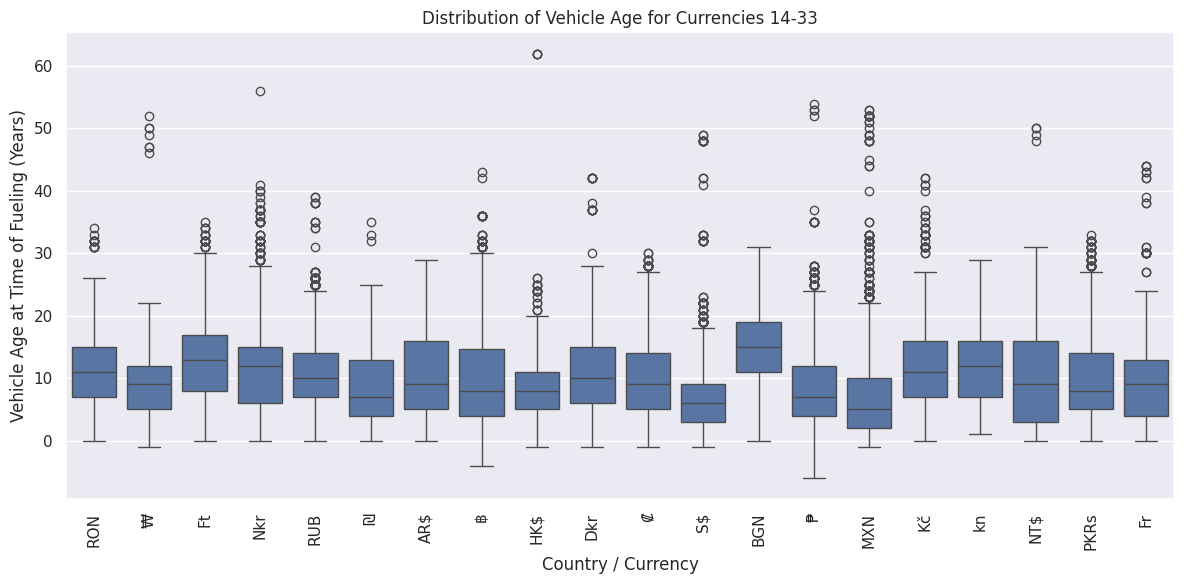

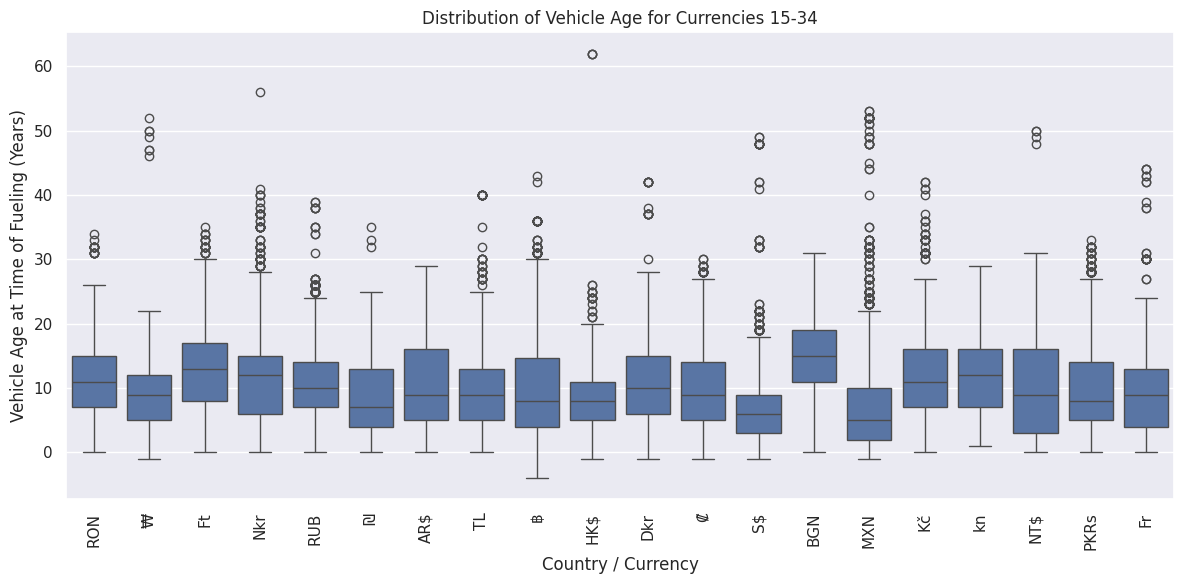

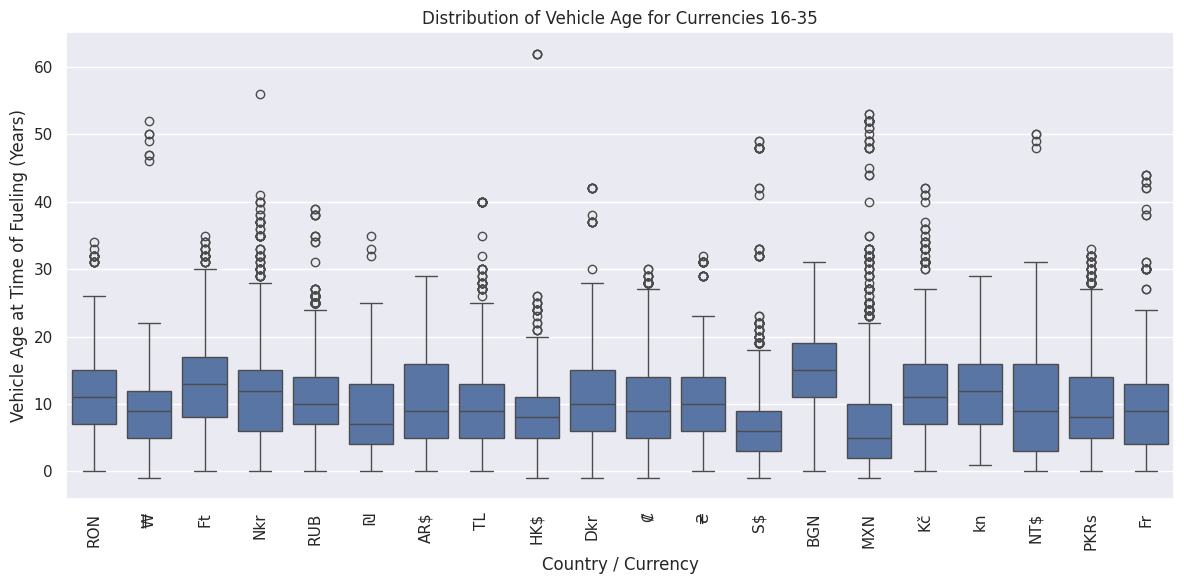

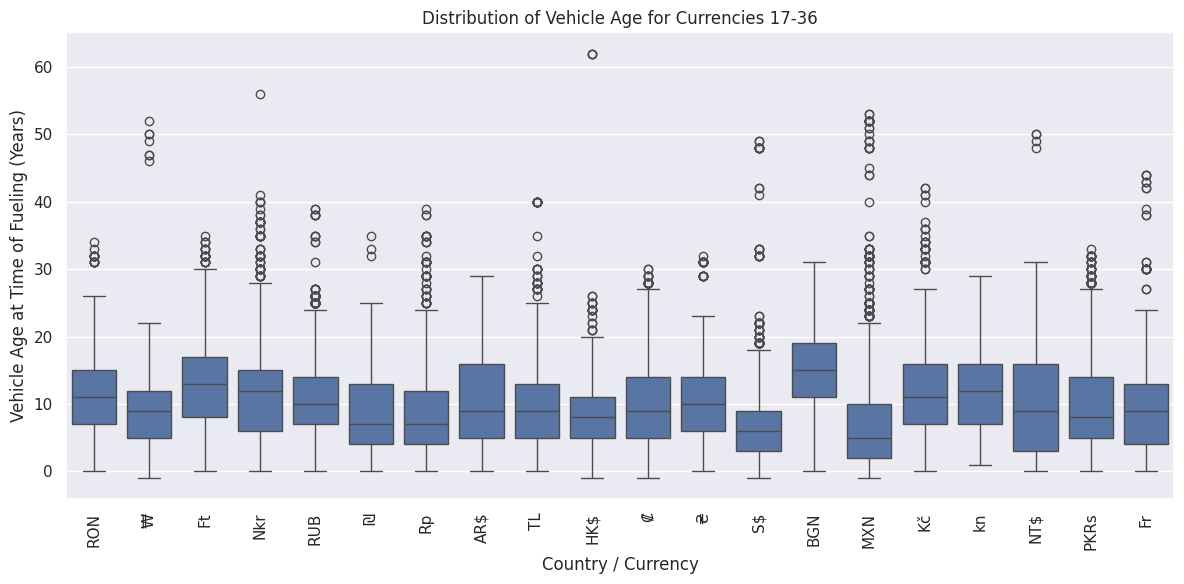

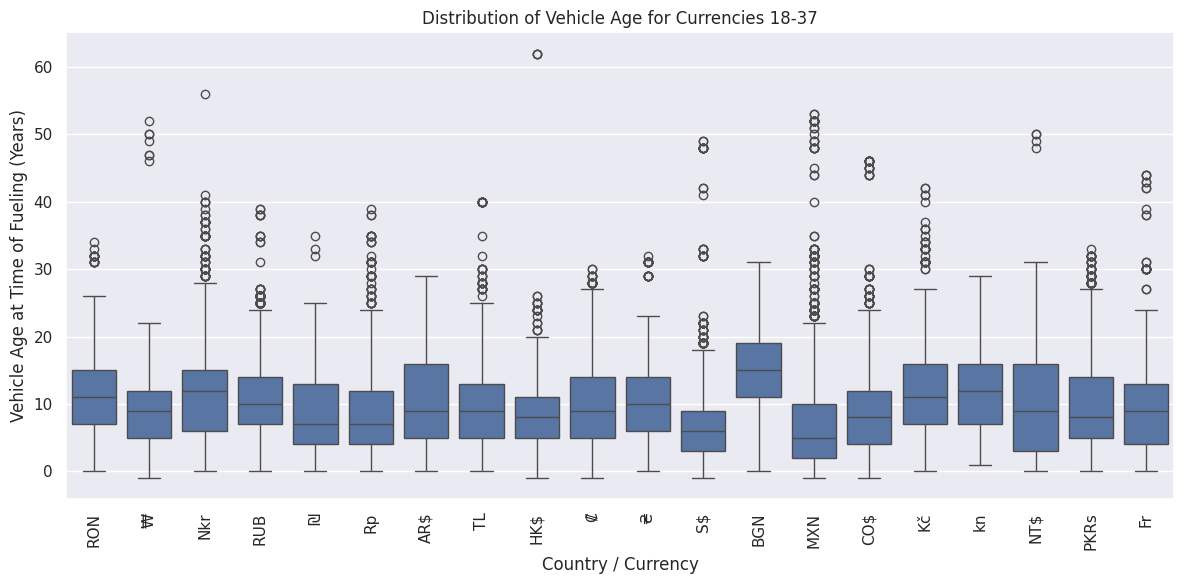

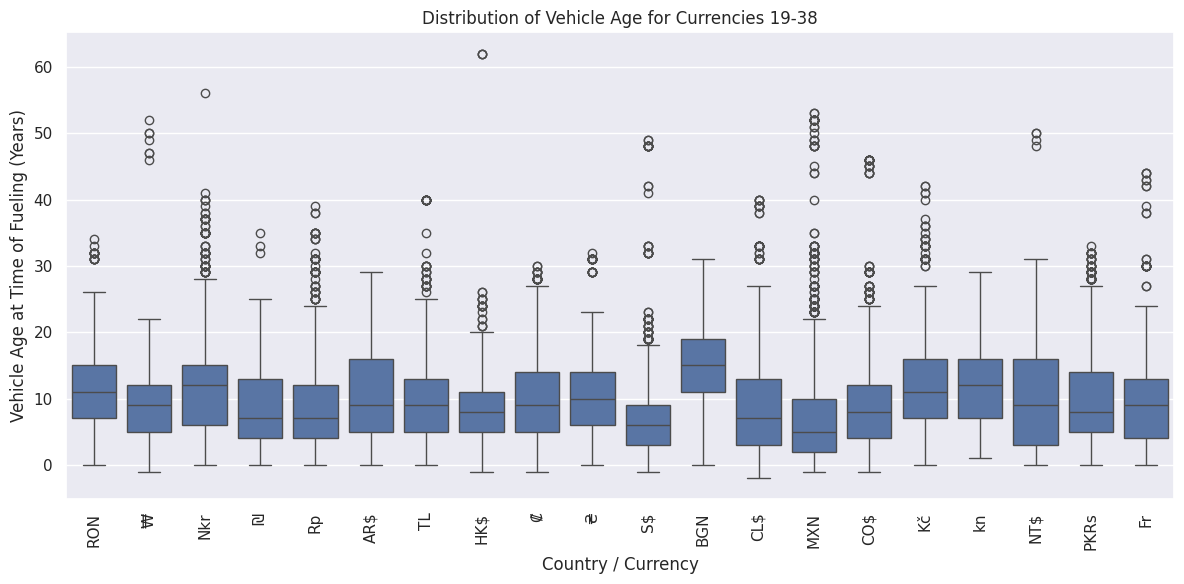

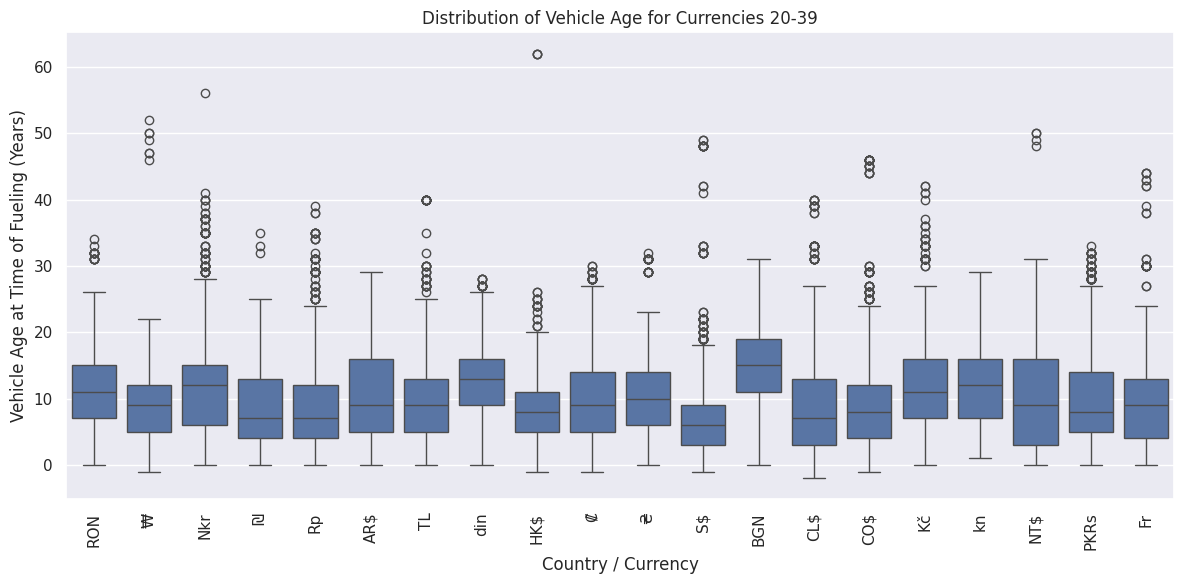

In [34]:
# Get unique currencies sorted by number of entries
df['vehicle_age'] = df['date_fueled_proxy'].dt.year - df['car_year']
currencies_sorted = df['currency'].value_counts().index

chunk_size = 20
for i in range(0, 20):
    chunk = currencies_sorted[i:i+chunk_size]
    plt.figure(figsize=(12,6))
    sns.boxplot(x='currency', y='vehicle_age', data=df[df['currency'].isin(chunk)])
    plt.xticks(rotation=90)
    plt.ylabel('Vehicle Age at Time of Fueling (Years)')
    plt.xlabel('Country / Currency')
    plt.title(f'Distribution of Vehicle Age for Currencies {i+1}-{i+len(chunk)}')
    plt.tight_layout()
    plt.show()

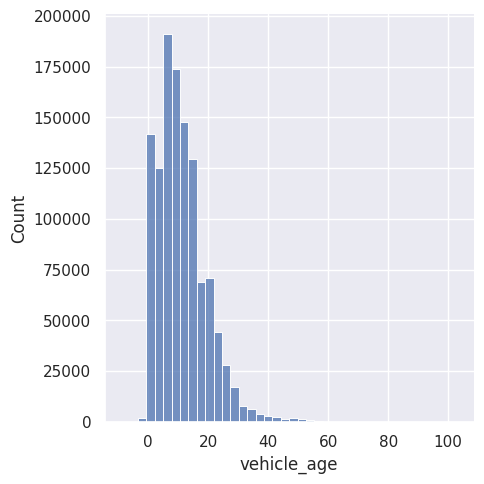

In [35]:
sns.displot(data=df, x= df['vehicle_age'], bins=40)

#### 4. Which makes and models of vehicles are the most popular?

In [36]:
most_popular_vehicle = df.groupby(['car_make', 'car_model']).car_make.count().reset_index(name='count')
most_popular_vehicle.nlargest(n=10, columns=['count'])

,car_make,car_model,count
692,honda,civic,8082
1937,toyota,4runner,7810
1972,toyota,corolla,7737
565,ford,f-150,7661
676,honda,accord,7633
627,ford,mustang,7520
642,ford,ranger,7424
2013,toyota,land_cruiser,7388
1964,toyota,camry,7316
888,jeep,wrangler,7061


In [37]:
df.sample(5)

,user_id,date_fueled_proxy,currency,total_spent_float,cpg_float,car_make,car_model,car_year,km_driven,litres_filled,...,cost_per_gallon,total_spent,date_fueled,date_captured,miles,odometer,gallons,mpg,user_url,vehicle_age
633056,1012231,2021-01-22,$,42.88,3.857,volkswagen,golf,2005.0,744.2669636480001,42.082422802728004,...,$3.857,$42.88,2021-01-22,2021-02-05,462.46720000000005,177896.0,11.117,41.6,https://www.somewebsite.com/volkswagen/golf/20...,16.0
472477,376830,2019-06-28,$,51.5,3.859,lexus,gs350,2008.0,549.843241984,50.520105669264,...,$3.859,$51.50,2019-06-28,2019-06-29,341.6576,127050.0,13.346,25.6,https://www.somewebsite.com/lexus/gs350/2008/3...,11.0
281764,1089513,2021-08-28,$,58.64,3.499,jeep,grand_cherokee,2016.0,671.536061028,63.435930676271994,...,$3.499,$58.64,2021-08-28,2021-08-28,417.27419999999995,101304.0,16.758,24.9,https://www.somewebsite.com/jeep/grand_cheroke...,5.0
284997,100138,2012-02-15,$,43.93,2.989,nissan,altima,1994.0,707.2088524019999,55.63419698944799,...,$2.989,$43.93,NaT,2012-02-15,439.4403,158737.0,14.697,29.9,https://www.somewebsite.com/nissan/altima/1994...,18.0
476828,1126975,2021-10-18,$,51.91,3.459,volkswagen,atlas,2020.0,458.87594221999996,56.807674642487996,...,$3.459,$51.91,2021-10-18,2022-02-17,285.133,19599.0,15.007,19.0,https://www.somewebsite.com/volkswagen/atlas/2...,1.0


## 4. Fuel Usage

#### 1. Identify the top 5 currencies by number of transactions.

In [38]:
# consistency reasons - cost per gallon is converted to cost per litre
# divide fuel price (U.S. gallon) by 3.785411784 to get cost per litre
df['cpl_float'] = df['cpg_float']/3.785411784

# top 5 currencies with most entries
# Replace the string 'nan' with real NaN
df['currency'] = df['currency'].replace('nan', np.nan)

# Now count top 5 currencies ignoring NaNs
top_currencies = df['currency'].value_counts(dropna=True).head(5).rename_axis('currency').reset_index(name='count')

df['currency'].value_counts().rename_axis('currency')[:5].reset_index(name='count')

,currency,count
0,$,741953
1,£,87587
2,€,59273
3,CA$,46848
4,R,36424


#### 2. For each of the top 5 currencies separately, remove outliers by considering the total spend, litres, cost per litre, gallons, etc.

In [41]:
top_currencies = ['$', '£', '€', 'CA$', 'R']
top_5_df = df[df['currency'].isin(top_currencies)]

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

numeric_cols = ['total_spent_float', 'litres_filled', 'cpl_float', 'gallons', 'km_driven', 'mpg', 'litres_per_100km']

cleaned_dfs = []

for cur in top_currencies:
    temp_df = top_5_df[top_5_df['currency'] == cur]
    for col in numeric_cols:
        if col in temp_df.columns:
            temp_df = remove_outliers_iqr(temp_df, col)
    cleaned_dfs.append(temp_df)

# Combine back
cleaned_top5_df = pd.concat(cleaned_dfs)

<span style="color:yellow">Handling more outliers from relationships across columns</span>

In [43]:
# Remove rows where total_spent_float differs from (litres_filled * cpl_float) by more than 10%
diff = abs(cleaned_top5_df['total_spent_float'] - (cleaned_top5_df['litres_filled'] * cleaned_top5_df['cpl_float']))
threshold = 0.10 * (cleaned_top5_df['litres_filled'] * cleaned_top5_df['cpl_float'])
mask = diff <= threshold
filtered_top5_df = cleaned_top5_df[mask]

# Calculate percentage of deleted rows
deleted_rows = cleaned_top5_df.shape[0] - filtered_top5_df.shape[0]
deleted_percentage = deleted_rows / cleaned_top5_df.shape[0] * 100
print(f'Rows deleted due to >10% difference: {deleted_rows} ({deleted_percentage:.2f}%)')

#update cleaned to filtered
cleaned_top5_df = filtered_top5_df

Rows deleted due to >10% difference: 0 (0.00%)


In [44]:
# Create vehicle column
cleaned_top5_df["vehicle"] = (
    cleaned_top5_df["car_make"].astype(str) + " " + cleaned_top5_df["car_model"].astype(str)
)

# Count vehicles per currency
vehicle_counts = cleaned_top5_df.groupby("currency")["vehicle"].value_counts().reset_index(name="count")

# Threshold: keep top 90% cumulative frequency per currency
def mark_rare(group, threshold=0.9):
    group = group.sort_values("count", ascending=False)
    group["cum_pct"] = group["count"].cumsum() / group["count"].sum()
    group["keep"] = group["cum_pct"] <= threshold
    return group

vehicle_thresholds = vehicle_counts.groupby("currency", group_keys=False).apply(mark_rare)

# Vehicles to keep
keep_set = set(
    zip(vehicle_thresholds.loc[vehicle_thresholds["keep"], "currency"],
        vehicle_thresholds.loc[vehicle_thresholds["keep"], "vehicle"])
)

# Filter rows
cleaned_top5_df = cleaned_top5_df[
    cleaned_top5_df.apply(lambda r: (r["currency"], r["vehicle"]) in keep_set, axis=1)
]


/tmp/ipykernel_1227/2033933164.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vehicle_thresholds = vehicle_counts.groupby("currency", group_keys=False).apply(mark_rare)


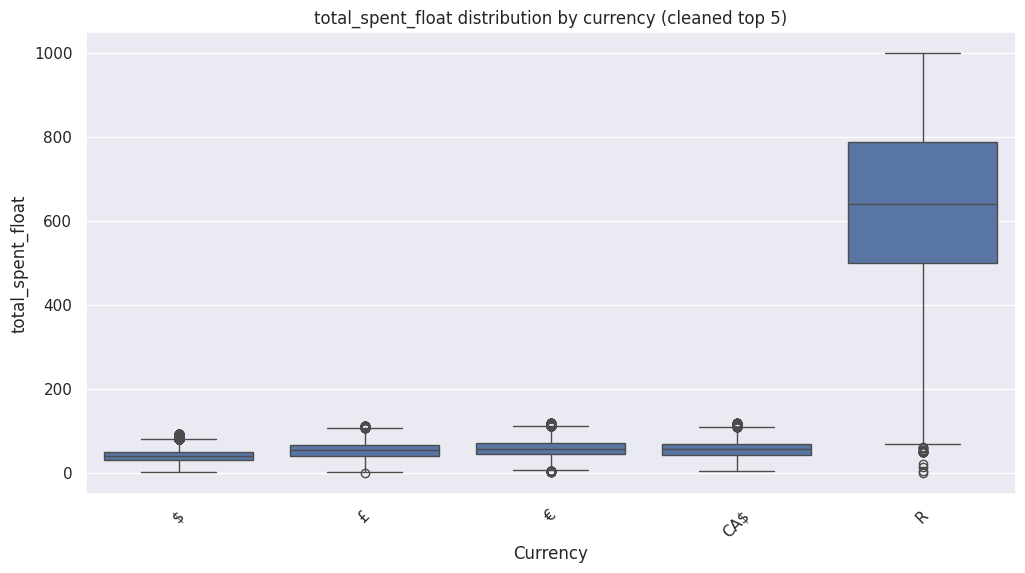

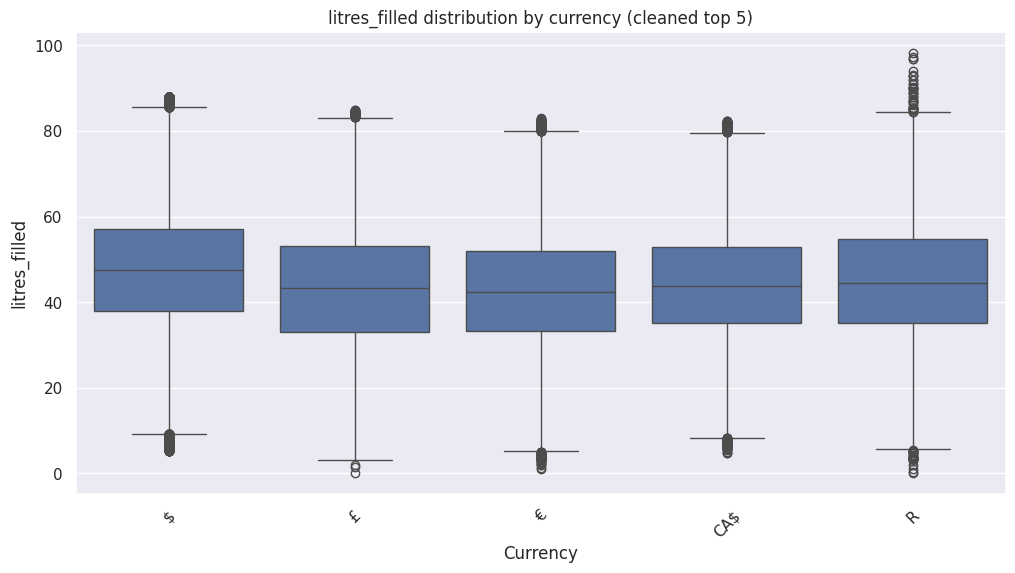

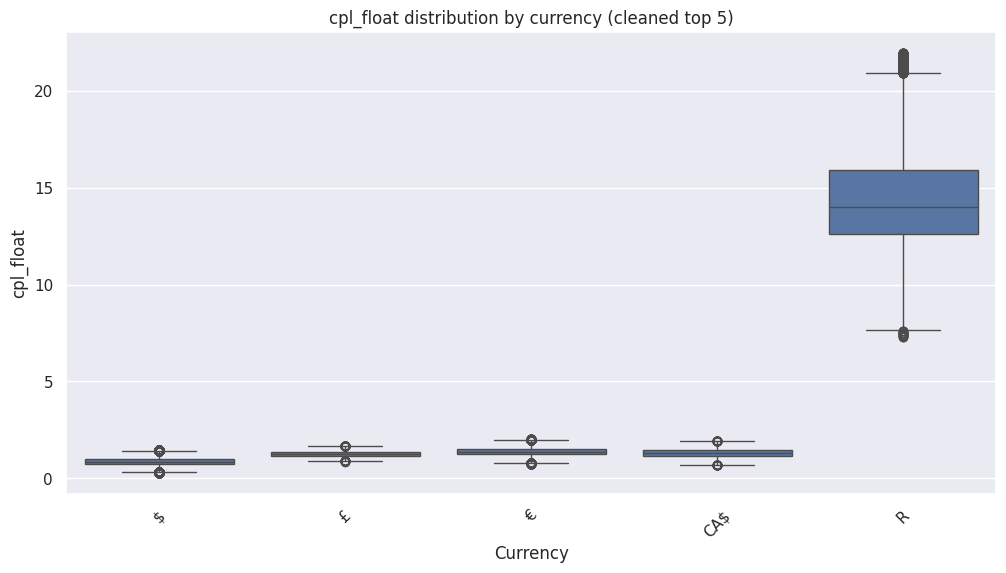

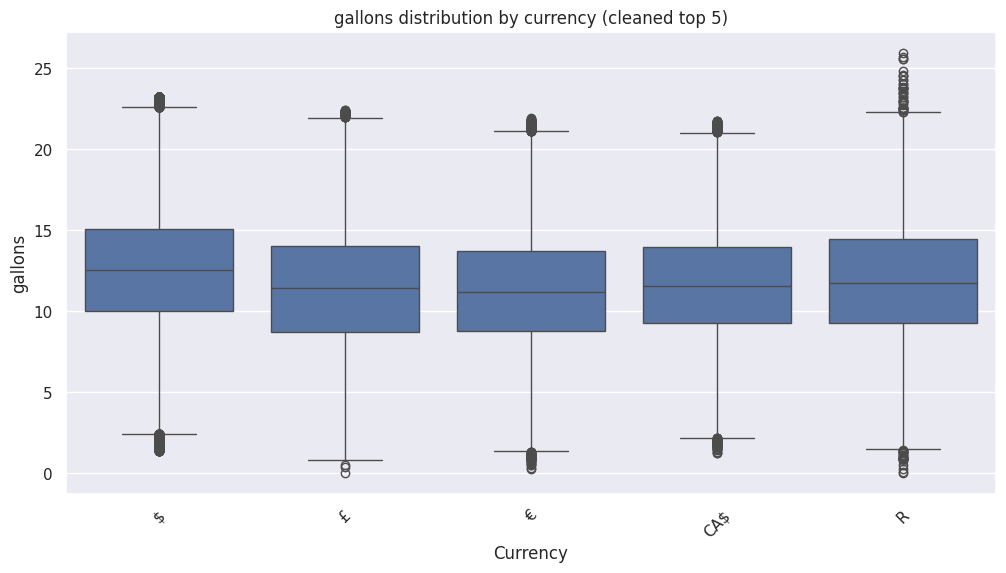

In [45]:
import seaborn as sns

numeric_cols = ['total_spent_float', 'litres_filled', 'cpl_float', 'gallons']

for col in numeric_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='currency', y=col, data=cleaned_top5_df)
    plt.xticks(rotation=45)
    plt.title(f'{col} distribution by currency (cleaned top 5)')
    plt.ylabel(col)
    plt.xlabel('Currency')
    plt.show()

In [ ]:
# (optional) ⁉️
# for col in numeric_cols:
#     plt.figure(figsize=(12,6))
#     sns.histplot(data=cleaned_top5_df, x=col, hue='currency', element='step', stat='density', common_norm=False)
#     plt.title(f'{col} distribution by currency (cleaned top 5)')
#     plt.xlabel(col)
#     plt.ylabel('Density')
#     plt.show()

<b>Reasoning</b>

#### Data Cleaning and Outlier Handling

##### 1. Separating by top 5 currencies
- The code filters the dataset to focus only on the most common currencies: `$`, `£`, `€`, `CA$`, `R`.
- This ensures that outlier removal and analysis are context-specific, because spending patterns, fuel prices, and vehicle types differ by currency.

##### 2. Outlier removal using IQR
- The function `remove_outliers_iqr` calculates Q1, Q3, and the interquartile range (IQR).
- Values outside `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]` are considered outliers and removed.
- This is robust because the IQR focuses on the central 50% of the data, ignoring extreme values.
- Using a multiplier of 1.5 is a standard statistical threshold that balances removing true anomalies while retaining legitimate variation.

##### 3. Column-wise cleaning
- Each numeric column (`total_spent_float`, `litres_filled`, `cpl_float`, `gallons`, `km_driven`, `mpg`, `litres_per_100km`) is cleaned independently.
- This ensures that outliers are removed in all dimensions, preventing one extreme value in any column from biasing analysis.

##### 4. Removing inconsistent `total_spent_float` values
- Rows where `total_spent_float` differs from (`litres_filled * cpl_float`) by more than 10% are removed.
- The 10% threshold is reasonable: it accounts for rounding errors, small entry mistakes, or minor reporting inconsistencies while removing large discrepancies.
- This step improves data integrity and ensures accurate calculations in downstream analysis.

##### 5. Vehicle frequency thresholding
- Vehicles are aggregated per currency, and cumulative frequency is computed.
- Keeping the top 90% cumulative frequency ensures that rare vehicles with few entries do not dominate analysis.
- The 90% threshold balances coverage and data quality: the majority of the data is retained while rare, possibly noisy cases are excluded.

##### 6. Overall justification
- The approach is systematic and reproducible: outliers are removed per currency, numerical inconsistencies are checked, and rare vehicles are filtered.
- Thresholds (1.5×IQR, 10% for total_spent differences, 90% cumulative frequency) are standard, interpretable, and practical.
- This ensures the cleaned dataset is robust, reliable, and representative, reducing the influence of extreme or inconsistent data on analysis.


#### 3. How many values have been removed after accounting for outliers?

In [47]:
# Original number of rows for top 5 currencies
original_count = top_5_df.shape[0]

# Number of rows after removing outliers
cleaned_count = cleaned_top5_df.shape[0]

# Number of rows removed
removed_count = original_count - cleaned_count

print(f'Original rows: {original_count}')
print(f'Rows after cleaning: {cleaned_count}')
print(f'Number of rows removed as outliers: {removed_count}')
print(f'Percentage of rows removed: {removed_count/original_count*100:.2f}%')

Original rows: 972085
Rows after cleaning: 626772
Number of rows removed as outliers: 345313
Percentage of rows removed: 35.52%


### 4.2. Fuel Efficiency


#### 1. Look at the difference in cost per litre per country for January 2022 - use the average currency conversion rate to Rands
https://www.nedbank.co.za/content/dam/nedbank/site-assets/AboutUs/Economics_Unit/Forecast_and_data/Daily_Rates/Monthly_Average_Exchange_Rates.pdf


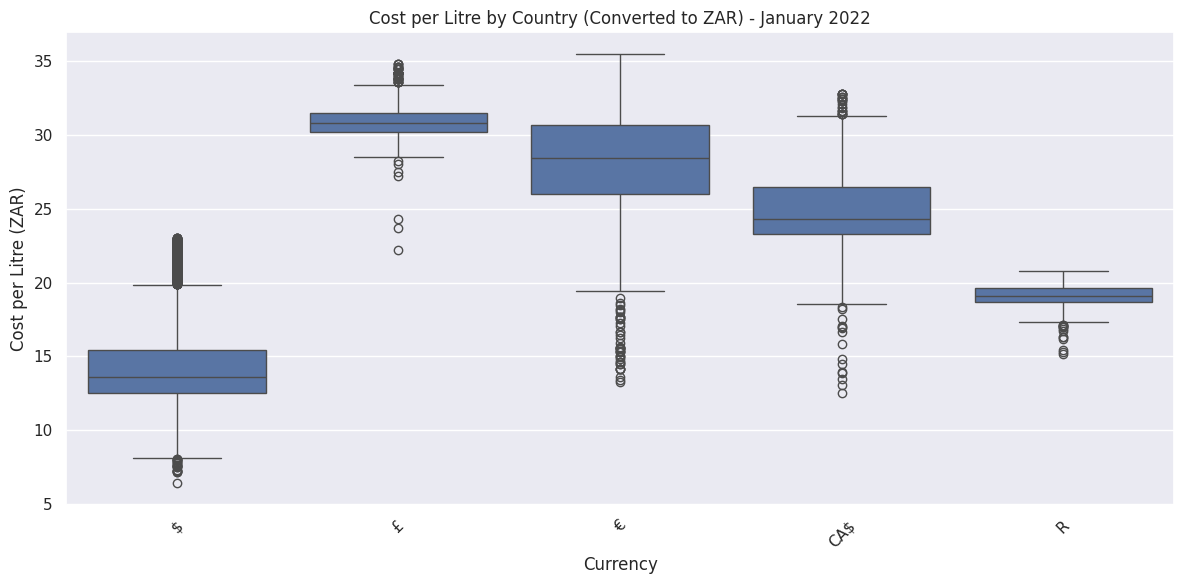

In [48]:
# Define exchange rates for January 2022
exchange_rates = {
    '$': 15.5972,  # USD to ZAR
    '€': 17.6922,  # EUR to ZAR
    '£': 21.1473,  # GBP to ZAR
    'CA$': 17.0088  # CAD to ZAR
}

# Filter for January 2022
jan_2022_df = cleaned_top5_df[
    (cleaned_top5_df['date_fueled_proxy'].dt.year == 2022) &
    (cleaned_top5_df['date_fueled_proxy'].dt.month == 1)
]

# Convert cost per litre to ZAR
jan_2022_df['cpl_zar'] = jan_2022_df.apply(
    lambda row: row['cpl_float'] * exchange_rates.get(row['currency'], 1)
    if row['currency'] in exchange_rates else row['cpl_float'],
    axis=1
)

# Plot the distribution for January 2022
plt.figure(figsize=(12, 6))
sns.boxplot(x='currency', y='cpl_zar', data=jan_2022_df)
plt.title('Cost per Litre by Country (Converted to ZAR) - January 2022')
plt.xlabel('Currency')
plt.ylabel('Cost per Litre (ZAR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




<span style="color:yellow">viewing plots from previous months could be helpful</span>

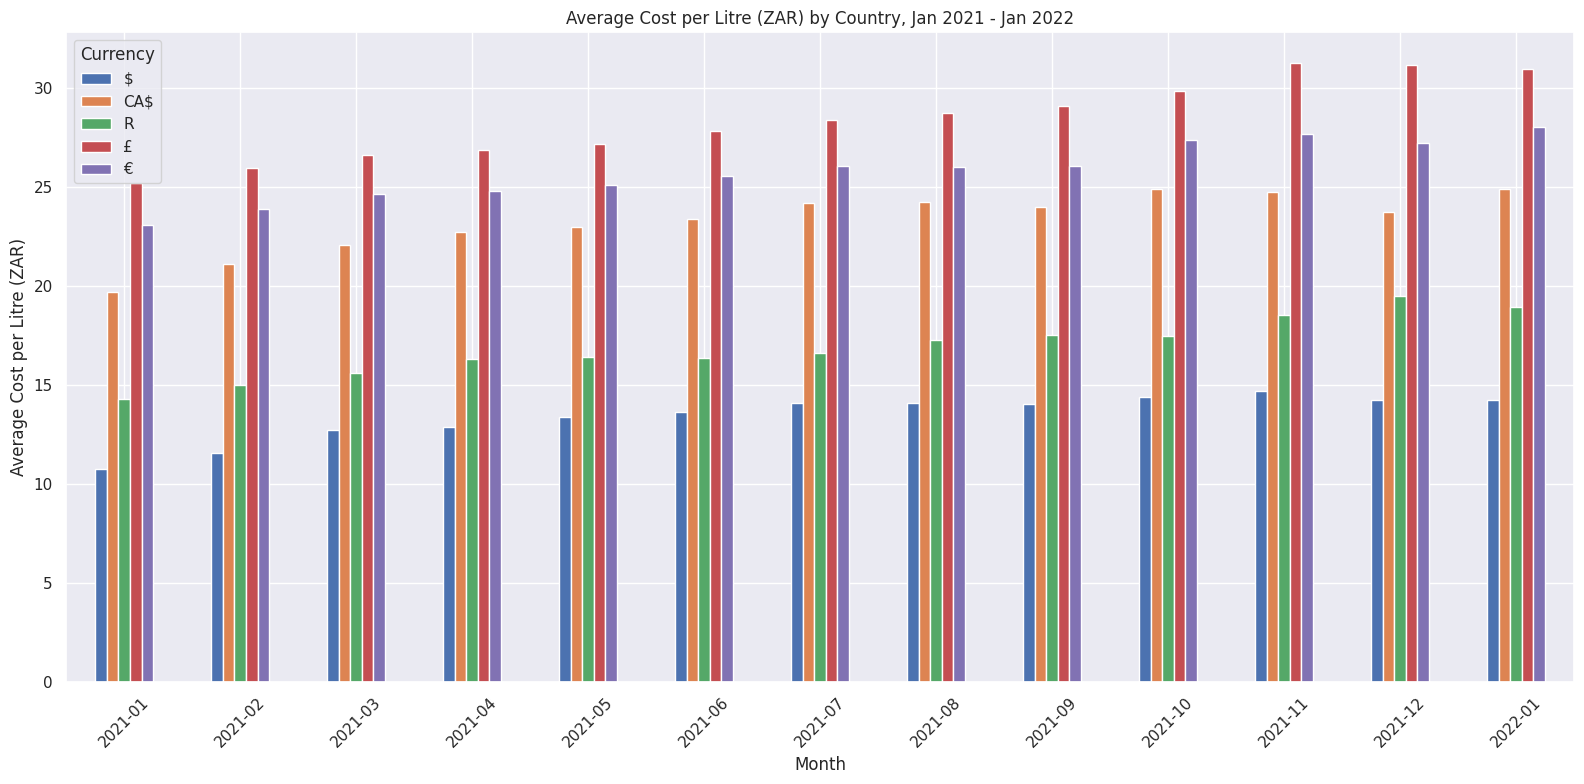

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Jan 2021 to Jan 2022
mask = (cleaned_top5_df['date_fueled_proxy'] >= '2021-01-01') & (cleaned_top5_df['date_fueled_proxy'] <= '2022-01-31')
monthly_df = cleaned_top5_df[mask].copy()

# If not already present, convert cost per litre to ZAR
exchange_rates = {
    '$': 15.5972,  # USD to ZAR
    '€': 17.6922,  # EUR to ZAR
    '£': 21.1473,  # GBP to ZAR
    'CA$': 17.0088  # CAD to ZAR
}
if 'cpl_zar' not in monthly_df.columns:
    monthly_df['cpl_zar'] = monthly_df.apply(
        lambda row: row['cpl_float'] * exchange_rates.get(row['currency'], 1)
        if row['currency'] in exchange_rates else row['cpl_float'],
        axis=1
    )

# Extract year and month
monthly_df['year_month'] = monthly_df['date_fueled_proxy'].dt.to_period('M')

# Group by year_month and currency, calculate mean cost per litre in ZAR
monthly_avg = monthly_df.groupby(['year_month', 'currency'])['cpl_zar'].mean().reset_index()

# Pivot for plotting
pivot_df = monthly_avg.pivot(index='year_month', columns='currency', values='cpl_zar')

# Plot bar chart for each month
pivot_df.plot(kind='bar', figsize=(16,8))
plt.title('Average Cost per Litre (ZAR) by Country, Jan 2021 - Jan 2022')
plt.xlabel('Month')
plt.ylabel('Average Cost per Litre (ZAR)')
plt.xticks(rotation=45)
plt.legend(title='Currency')
plt.tight_layout()
plt.savefig('average_cpl_by_currency_4.2.1.jpeg', dpi=300)  # quality optional
plt.show()

#### 2. Looking at the odometer readings, find examples of where users have missed logging a fill-up. Give a basic rule for identifying this, and estimate how many there are in the dataset.

In [53]:
# Ensure date_fueled_proxy is datetime
cleaned_top5_df = cleaned_top5_df.sort_values(['user_id', 'date_fueled_proxy'])
# Compute difference in km driven between consecutive logs for each user
cleaned_top5_df['km_diff'] = cleaned_top5_df.groupby('user_id')['km_driven'].diff()
# km_diff is NaN for the first fill-up per user.
# Large values of km_diff may indicate missed fill-ups.

# Example: flag km_diff greater than 2 times the user's median distance per fill-up
cleaned_top5_df['median_km'] = cleaned_top5_df.groupby('user_id')['km_driven'].transform('median')
cleaned_top5_df['missed_fillup'] = cleaned_top5_df['km_diff'] > 2 * cleaned_top5_df['median_km']

# Show examples
missed_examples = cleaned_top5_df[cleaned_top5_df['missed_fillup']][['user_id', 'date_fueled_proxy', 'odometer', 'km_diff']]
print(missed_examples.head(10))


        user_id date_fueled_proxy  odometer            km_diff
651046   101552        2012-04-16       NaN           635.6893
965753  1021272        2020-01-19   77378.0       654.57651424
791260   102979        2013-03-19       NaN         534.783682
823523  1055904        2022-02-13  101370.0  399.1689454180001
522853  1071108        2022-04-03   70531.0      638.907658132
147672  1073763        2021-10-24  173213.0  727.8196697819999
298024  1078997        2021-07-13   21122.0       585.72573036
283858  1081729        2022-02-17  110430.0 329.91647027400006
15033   1096567        2021-10-19   97852.0      541.008126318
367316  1121890        2022-04-08   46697.0      408.049444472


Basic Rule

- Sort by user and fueling date.
- Compute km_diff between consecutive refuels.
- If km_diff > 1.5 × median km per fill-up for that user, flag as potential missed fill-up.
- Threshold can be adjusted based on typical driving patterns.
- This is a simple, heuristic approach; more advanced methods can consider MPG, fuel tank size, or expected distances.

#### 3. Plot the average distance (in km) per tank per country. Which country has the largest average distance? Provide some explanations for why this might be the case.

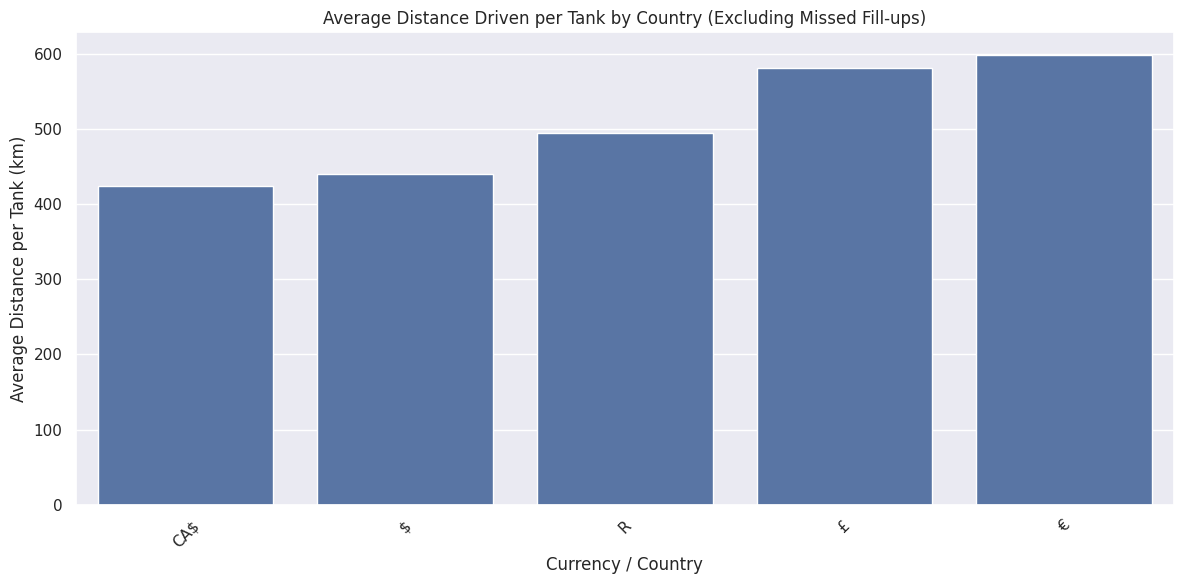

Country with largest average distance: € (598.4 km per tank)


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows flagged as missed fill-ups
cleaned_top5_df = cleaned_top5_df[~cleaned_top5_df['missed_fillup']]

# Group by currency and calculate mean km per tank
avg_distance_per_currency = cleaned_top5_df.groupby('currency')['km_driven'].mean().sort_values()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=avg_distance_per_currency.index, y=avg_distance_per_currency.values)
plt.xlabel('Currency / Country')
plt.ylabel('Average Distance per Tank (km)')
plt.title('Average Distance Driven per Tank by Country (Excluding Missed Fill-ups)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_distance_per_tank_4.2.3.jpeg', dpi=300)  # Lower resolution but still clear
plt.show()

# Identify country with largest average distance
max_currency = avg_distance_per_currency.idxmax()
max_distance = avg_distance_per_currency.max()
print(f'Country with largest average distance: {max_currency} ({max_distance:.1f} km per tank)')


Country with largest average distance: € (598.4 km per tank)
    The reason for this might be that cars in other countries are simply not as fuel-efficient as those in €. These cars are designed to accommodate € fuel prices, which are probably far higher than other countries fuel prices. As a result, € vehicles allow drivers to achieve greater miles per gallon (km per litre).

#### 4. Do newer vehicles drive further distances between fill-ups? Provide a plot to show this. 

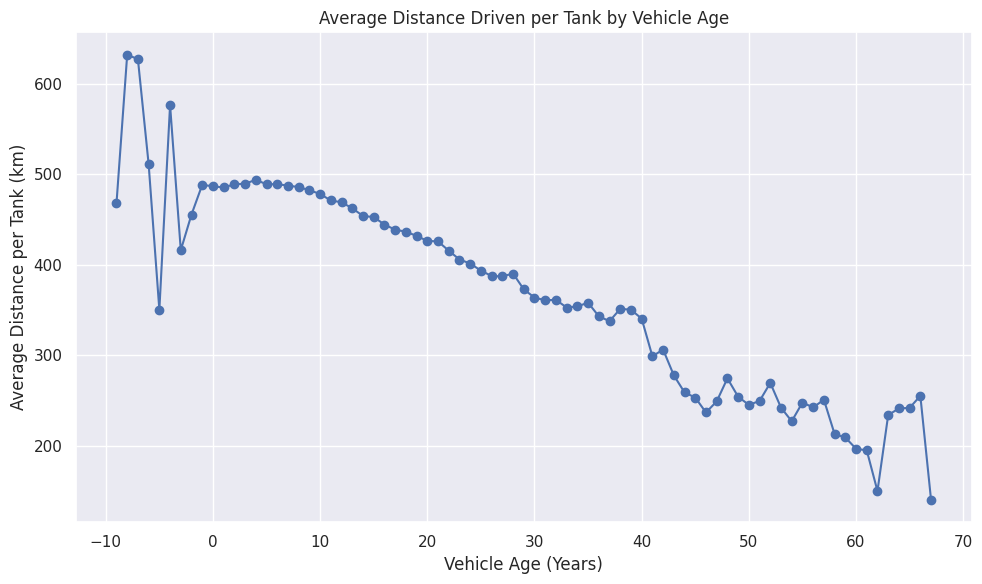

In [60]:
avg_distance_per_age = cleaned_top5_df.groupby('vehicle_age')['km_driven'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_distance_per_age.index, avg_distance_per_age.values, marker='o')
plt.title('Average Distance Driven per Tank by Vehicle Age')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Average Distance per Tank (km)')
plt.grid(True)
plt.tight_layout()
# fig.savefig('avg_dist_per_vehicle_age_4.2.4.jpeg', dpi=150)
plt.show()


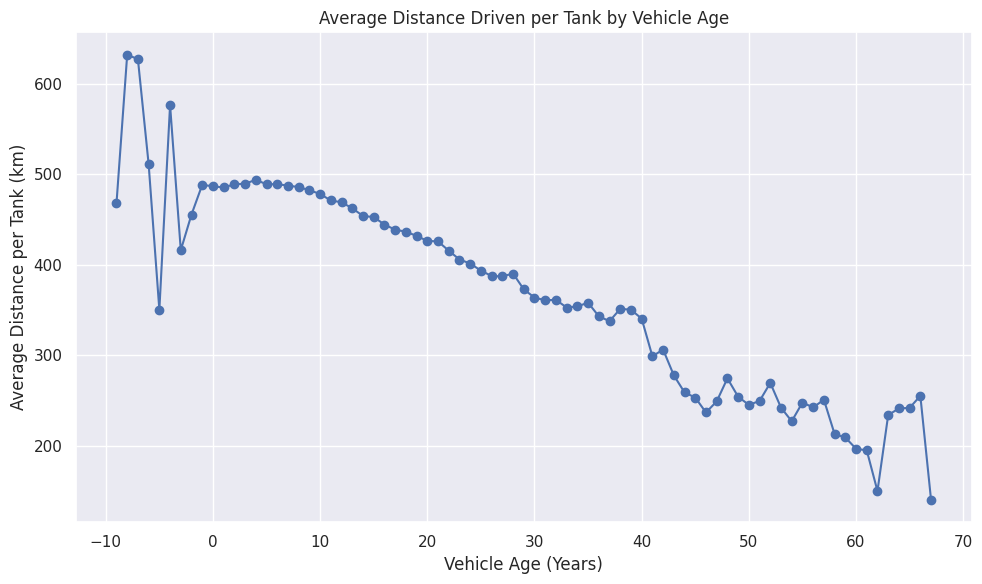

In [61]:
import matplotlib.pyplot as plt

# Compute average distance per vehicle age
avg_distance_per_age = cleaned_top5_df.groupby('vehicle_age')['km_driven'].mean()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot
ax.plot(avg_distance_per_age.index, avg_distance_per_age.values, marker='o')
ax.set_title('Average Distance Driven per Tank by Vehicle Age')
ax.set_xlabel('Vehicle Age (Years)')
ax.set_ylabel('Average Distance per Tank (km)')
ax.grid(True)
plt.tight_layout()

# Save as JPEG (dpi=150 for smaller file but clear)
fig.savefig('avg_distance_per_vehicle_age.jpeg', dpi=150)

# Display plot
plt.show()


#### 5. Take the top 5 most popular vehicles in SA (ie, those with currency set to R). Compute their fuel efficiency and discuss whether these values are realistic.

Top 5 vehicles in SA: Index(['suzuki jimny', 'toyota hilux', 'mitsubishi pajero', 'volkswagen polo',
       'toyota fortuner'],
      dtype='object', name='vehicle')

 
  vehicle
mitsubishi pajero   12.545947390254506
toyota hilux         11.95873492773363
toyota fortuner     11.039257575046449
suzuki jimny         9.172396256598883
volkswagen polo      7.728291565001874
Name: litres_per_100km, dtype: float64


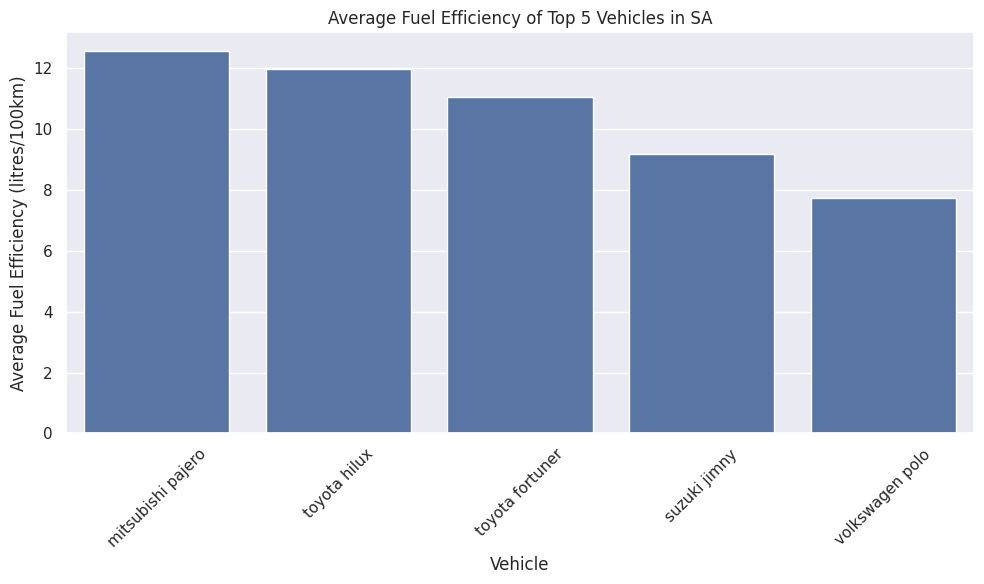

In [62]:
# Filter for South Africa
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R']

# Count most popular vehicles
sa_df['vehicle'] = sa_df['car_make'] + ' ' + sa_df['car_model']
top5_vehicles = sa_df['vehicle'].value_counts().head(5).index
print("Top 5 vehicles in SA:", top5_vehicles)

# Filter only top 5 vehicles
top5_sa_df = sa_df[sa_df['vehicle'].isin(top5_vehicles)]

# Compute average fuel efficiency per vehicle
fuel_efficiency = top5_sa_df.groupby('vehicle')['litres_per_100km'].mean().sort_values(ascending=False)
print("\n \n ",fuel_efficiency)

plt.figure(figsize=(10,6))
sns.barplot(x=fuel_efficiency.index, y=fuel_efficiency.values)
plt.ylabel('Average Fuel Efficiency (litres/100km)')
plt.xlabel('Vehicle')
plt.title('Average Fuel Efficiency of Top 5 Vehicles in SA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


These values are realistic given vehicle type and size. SUVs and pickups consume more fuel than smaller cars like the Polo and Jimny. Overall, the fuel efficiencies align with expected real-world values in South Africa.

#### 6. Which vehicles are the most fuel efficient in each country?

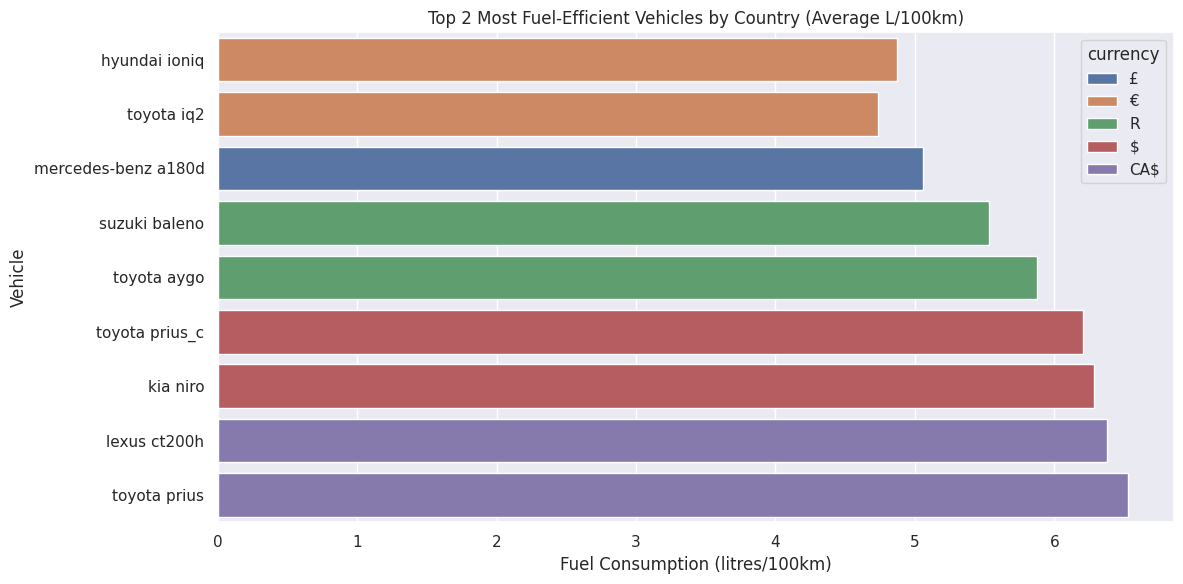

In [64]:
# Identify average fuel efficiency (litres per 100 km) per vehicle and country
vehicle_efficiency = (
    cleaned_top5_df
    .groupby(['car_make', 'car_model', 'currency'])['litres_per_100km']
    .mean()
    .reset_index(name='avg_litres_per_100km')
)

# Select top 2 most fuel-efficient vehicles per country
most_efficient_vehicles = (
    vehicle_efficiency
    .sort_values('avg_litres_per_100km')
    .groupby('currency')
    .head(2)
)

# Combine make and model for readability
most_efficient_vehicles['vehicle'] = (
    most_efficient_vehicles['car_make'] + ' ' + most_efficient_vehicles['car_model']
)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    x='avg_litres_per_100km',
    y='vehicle',
    data=most_efficient_vehicles.sort_values('avg_litres_per_100km'),
    hue='currency',
    dodge=False
)
plt.title('Top 2 Most Fuel-Efficient Vehicles by Country (Average L/100km)')
plt.xlabel('Fuel Consumption (litres/100km)')
plt.ylabel('Vehicle')
plt.tight_layout()
plt.savefig('most_efficient_vehicles.jpeg', dpi=200)  # dpi=200 for decent resolution
plt.show()


Grouping the top 2 vehicles per country keeps the plot clear and focuses on the most fuel-efficient models. GBP shows only 1 vehicle because the dataset contains only one qualifying vehicle for that currency after cleaning.

To ensure the values are reasonable, we can compare the calculated fuel efficiencies with known benchmarks for typical fuel consumption:
- Suzuki Celerio 1.0 GL: 4.2 L/100km
- Toyota Vitz 1.0 XR: 4.2 L/100km
- Renault Kwid: 4.4 L/100km
- Suzuki Swift 1.2: 4.4 L/100km
- Suzuki S-Presso 1.0: 4.6 L/100km
- Volkswagen Polo Vivo GT 1.0 TSI: 4.8 L/100km
- Honda Jazz: 5.6 L/100km
- Volkswagen Polo: 5.7 L/100km
* These figures are based on manufacturer claims and real-world data .

#### 7. Plot the difference in fuel efficiency for the top 5 Canadian vehicles between seasons. Would you expect to see big differences, and do you see them?

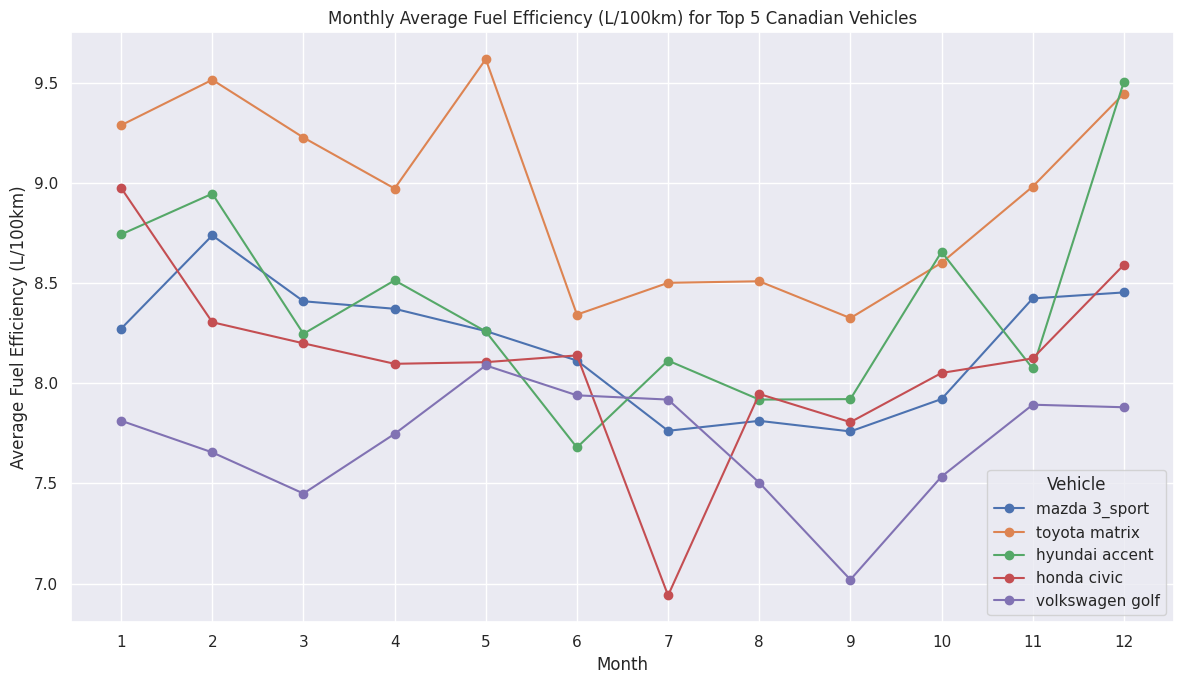

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Canadian vehicles
ca_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'CA$'].copy()

# Get top 5 most popular Canadian vehicles
ca_df['vehicle'] = ca_df['car_make'] + ' ' + ca_df['car_model']
top5_ca_vehicles = ca_df['vehicle'].value_counts().head(5).index

# Filter only top 5 vehicles
ca_top5 = ca_df[ca_df['vehicle'].isin(top5_ca_vehicles)]

# Group by vehicle and month, then calculate mean fuel efficiency
monthly_eff = ca_top5.groupby([ca_top5['date_fueled_proxy'].dt.month, 'vehicle'])['litres_per_100km'].mean().reset_index()

plt.figure(figsize=(12, 7))
for vehicle in top5_ca_vehicles:
    data = monthly_eff[monthly_eff['vehicle'] == vehicle]
    plt.plot(data['date_fueled_proxy'], data['litres_per_100km'], marker='o', label=vehicle)

plt.title('Monthly Average Fuel Efficiency (L/100km) for Top 5 Canadian Vehicles')
plt.ylabel('Average Fuel Efficiency (L/100km)')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.legend(title='Vehicle')
plt.tight_layout()
plt.show()


<span style="color:yellow">Changing plot ranges to look at it seasonaly</span>

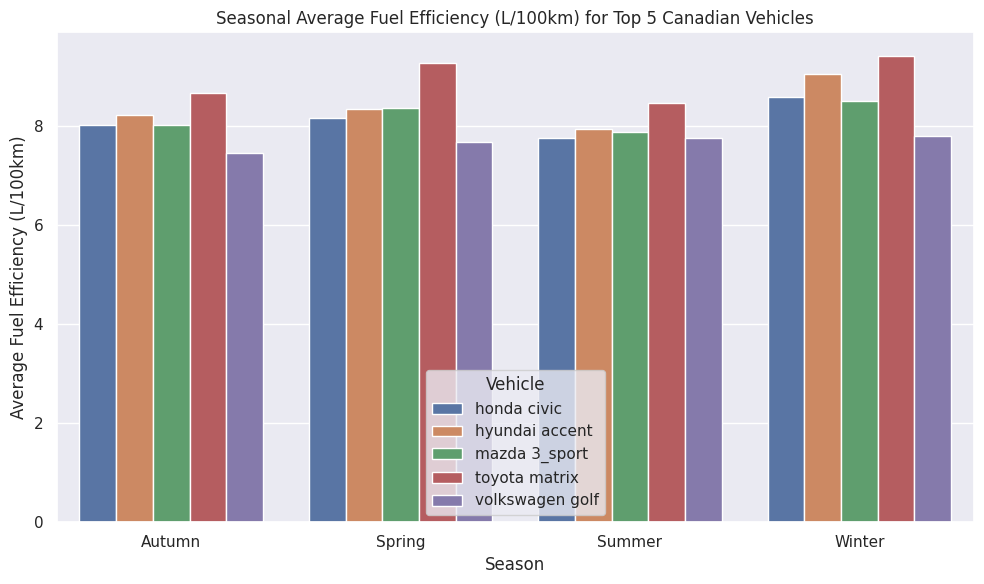

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define Canadian seasons by month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Filter for Canadian vehicles
ca_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'CA$'].copy()
ca_df['vehicle'] = ca_df['car_make'] + ' ' + ca_df['car_model']
top5_ca_vehicles = ca_df['vehicle'].value_counts().head(5).index
ca_top5 = ca_df[ca_df['vehicle'].isin(top5_ca_vehicles)].copy()

# Add season column
ca_top5['season'] = ca_top5['date_fueled_proxy'].dt.month.apply(get_season)

# Group by vehicle and season, then calculate mean fuel efficiency
seasonal_eff = ca_top5.groupby(['season', 'vehicle'])['litres_per_100km'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='litres_per_100km', hue='vehicle', data=seasonal_eff)
plt.title('Seasonal Average Fuel Efficiency (L/100km) for Top 5 Canadian Vehicles')
plt.ylabel('Average Fuel Efficiency (L/100km)')
plt.xlabel('Season')
plt.legend(title='Vehicle')
plt.tight_layout()
plt.savefig('seasonal_fuel_efficiency_ca.jpeg', dpi=200)  # dpi=200 for clear resolution
plt.show()

Fuel expands when warm, increasing its measured volume. This can make fuel efficiency (litres per 100 km) appear lower than actual, since more litres are recorded for the same distance, slightly biasing comparisons unless temperature effects are considered.

#### 8. Show the correlations between fuel efficiency and other features. You should find that there is a relative strongly correlation with distance travelled, the age of the vehicle, and the model of vehicle. 

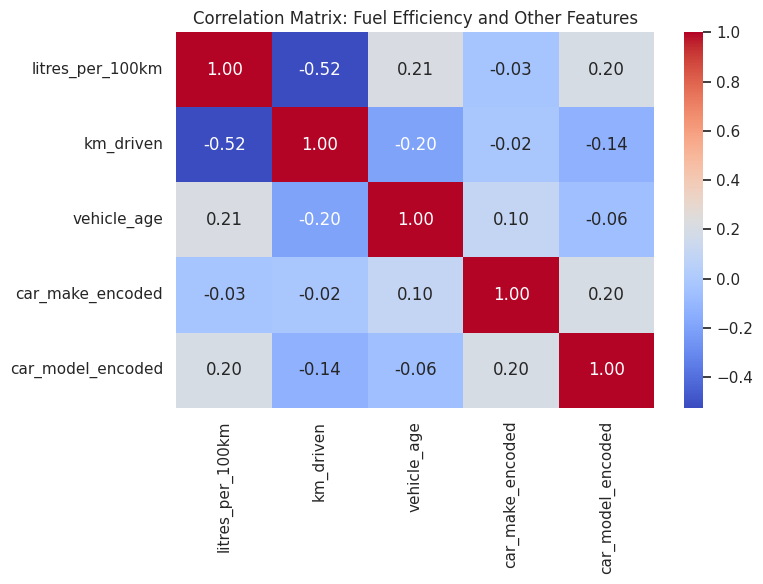

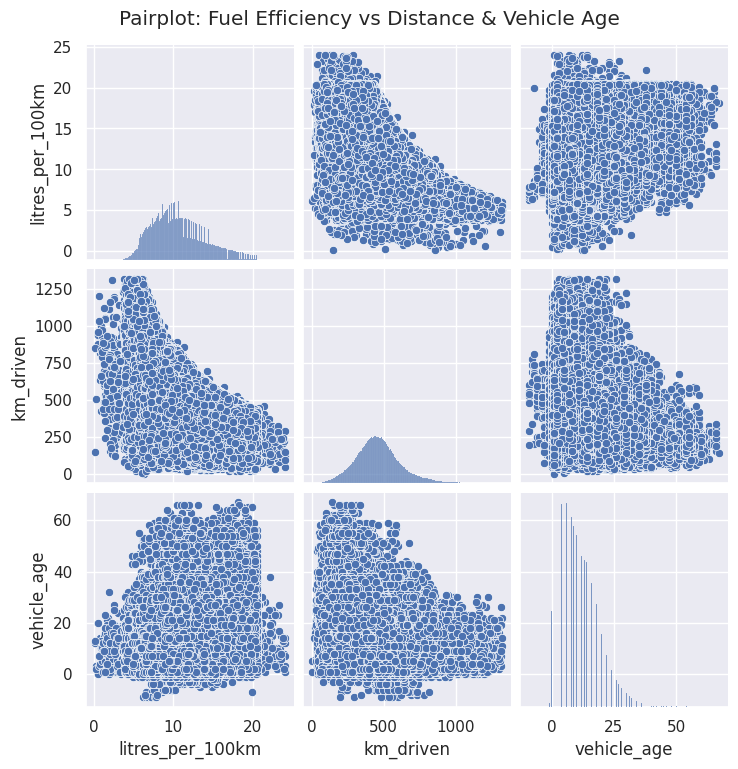

In [70]:
# Correlation analysis: Fuel efficiency vs other features
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation
corr_features = ['litres_per_100km', 'km_driven', 'vehicle_age', 'car_make', 'car_model']

# Encode categorical variables (car_make, car_model) for correlation
from sklearn.preprocessing import LabelEncoder
df_corr = cleaned_top5_df.copy()
df_corr['car_make_encoded'] = LabelEncoder().fit_transform(df_corr['car_make'].astype(str))
df_corr['car_model_encoded'] = LabelEncoder().fit_transform(df_corr['car_model'].astype(str))

# Compute correlation matrix
corr_matrix = df_corr[['litres_per_100km', 'km_driven', 'vehicle_age', 'car_make_encoded', 'car_model_encoded']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Fuel Efficiency and Other Features')
plt.tight_layout()
plt.savefig('fuel_efficiency_correlation_heatmap.jpeg', dpi=200)
plt.show()

# Show pairplot for visual relationships
sns.pairplot(df_corr, vars=['litres_per_100km', 'km_driven', 'vehicle_age'])
plt.suptitle('Pairplot: Fuel Efficiency vs Distance & Vehicle Age', y=1.02)
plt.show()

<span style="color:yellow">Could not get meaningful intepretations from the plots above need help</span>

Litres per 100 km vs km_driven: Strong negative correlation. Cars driven longer distances tend to have lower fuel consumption per 100 km, likely due to highway driving efficiency.
        
Litres per 100 km vs vehicle_age: Slight positive correlation. Older vehicles generally consume more fuel.
        
Car make/model vs fuel efficiency: Correlations exist due to vehicle design differences; larger or less efficient models show higher L/100 km.

9. Use a random forest to get a list of the most important variables. How
different are they from each other, and how do these relate to the variables
from the correlations above? 

In [90]:
cleaned_top5_df.dtypes

user_id                      object
date_fueled_proxy    datetime64[ns]
currency                     object
total_spent_float           float64
cpg_float                   float64
car_make                     object
car_model                    object
car_year                    float64
km_driven                   float64
litres_filled               float64
litres_per_100km            float64
cost_per_gallon              object
total_spent                  object
date_fueled          datetime64[ns]
date_captured        datetime64[ns]
miles                       float64
odometer                    float64
gallons                     float64
mpg                         float64
user_url                     object
vehicle_age                 float64
cpl_float                   float64
vehicle                      object
km_diff                     float64
median_km                   float64
missed_fillup                  bool
dtype: object

Feature columns used for Random Forest:
['km_driven', 'vehicle_age', 'car_make_encoded', 'car_model_encoded', 'total_spent_float', 'litres_filled', 'cpl_float', 'gallons', 'mpg', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


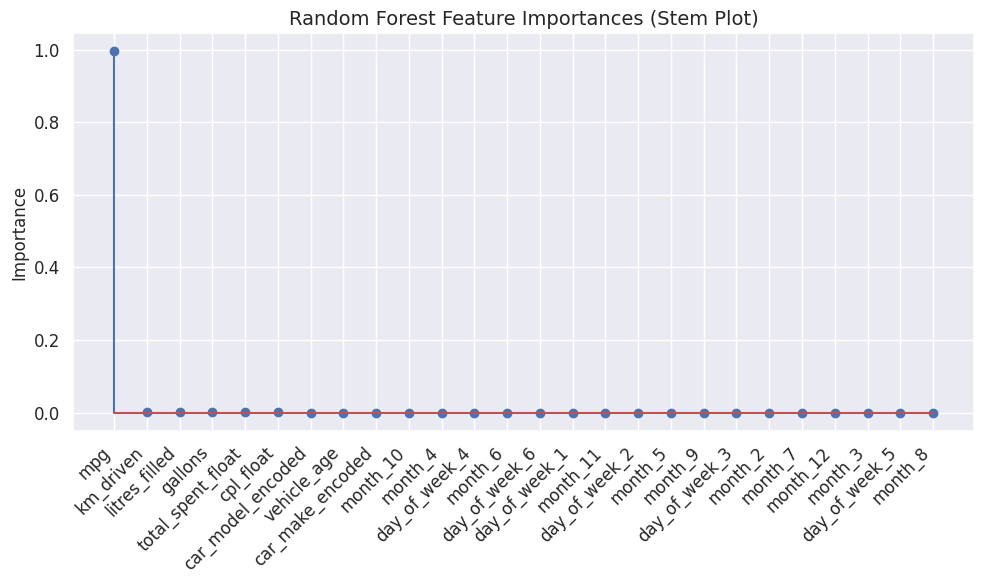

Feature importances (descending):
mpg: 0.9957
km_driven: 0.0017
litres_filled: 0.0010
gallons: 0.0009
total_spent_float: 0.0003
cpl_float: 0.0002
car_model_encoded: 0.0001
vehicle_age: 0.0001
car_make_encoded: 0.0000
month_10: 0.0000
month_4: 0.0000
day_of_week_4: 0.0000
month_6: 0.0000
day_of_week_6: 0.0000
day_of_week_1: 0.0000
month_11: 0.0000
day_of_week_2: 0.0000
month_5: 0.0000
month_9: 0.0000
day_of_week_3: 0.0000
month_2: 0.0000
month_7: 0.0000
month_12: 0.0000
month_3: 0.0000
day_of_week_5: 0.0000
month_8: 0.0000


In [91]:
# Random Forest feature importance for fuel efficiency (stem plot)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
# Copy working dataframe
df_rf = cleaned_top5_df.copy()

# Extract temporal features
df_rf['month'] = df_rf['date_fueled_proxy'].dt.month               # 1-12
df_rf['day_of_week'] = df_rf['date_fueled_proxy'].dt.dayofweek     # 0=Monday, 6=Sunday

# Example: one-hot encode month and day_of_week
df_rf = pd.get_dummies(df_rf, columns=['month', 'day_of_week'], drop_first=True)

# Encode car_make and car_model as numeric labels
from sklearn.preprocessing import LabelEncoder
df_rf['car_make_encoded'] = LabelEncoder().fit_transform(df_rf['car_make'].astype(str))
df_rf['car_model_encoded'] = LabelEncoder().fit_transform(df_rf['car_model'].astype(str))

# Features
features = [
    'km_driven', 'vehicle_age', 'car_make_encoded', 'car_model_encoded',
    'total_spent_float', 'litres_filled', 'cpl_float', 'gallons', 'mpg'
] + [col for col in df_rf.columns if col.startswith('month') or col.startswith('day_of_week')]

X = df_rf[features]
y = df_rf['litres_per_100km']

print("Feature columns used for Random Forest:")
print(features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
feature_names = [features[i] for i in indices]

# Stem plot (no use_line_collection)
plt.figure(figsize=(10, 6))
(markerline, stemlines, baseline) = plt.stem(range(len(importances)), importances[indices])
plt.setp(markerline, 'markerfacecolor', 'b')
plt.setp(stemlines, 'color', 'b')
plt.yticks(fontsize=12)
plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right', fontsize=12)
plt.title('Random Forest Feature Importances (Stem Plot)', fontsize=14)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("Feature importances (descending):")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {importances[indices][i]:.4f}")

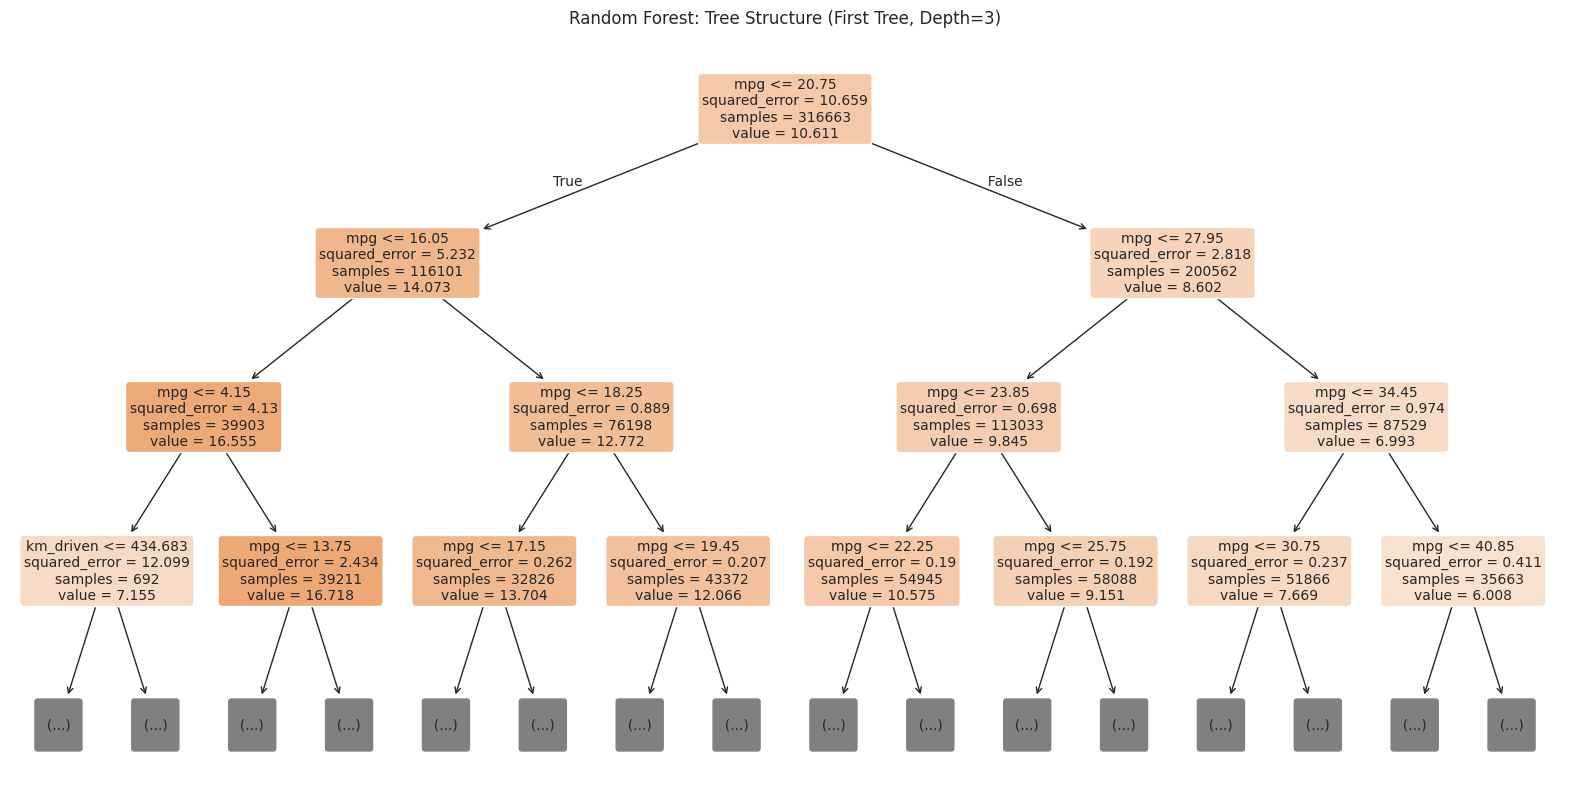

In [92]:
from sklearn.tree import plot_tree

# Visualize the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=features, filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title('Random Forest: Tree Structure (First Tree, Depth=3)')
plt.show()

<span style="color:yellow">Failed attempt at making this look like a traditional decision tree need help</span>

4.3 1. Filter the above dataset to focus on SA drivers.

In [83]:
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R'].copy()

2. Plot the fuel prices over time for SA. 

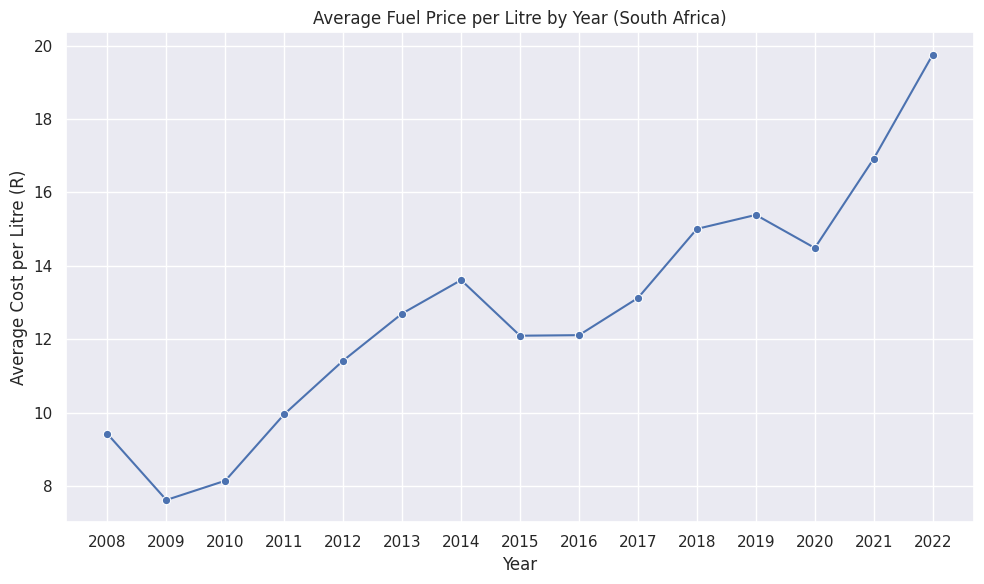

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for South African drivers
sa_df = cleaned_top5_df[cleaned_top5_df['currency'] == 'R'].copy()

# Group by year and calculate mean cost per litre
sa_df['year'] = sa_df['date_fueled_proxy'].dt.year
yearly_prices = sa_df.groupby('year')['cpl_float'].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=yearly_prices['year'], y=yearly_prices['cpl_float'], marker='o')
plt.title('Average Fuel Price per Litre by Year (South Africa)')
plt.xlabel('Year')
plt.ylabel('Average Cost per Litre (R)')
plt.xticks(yearly_prices['year'])
plt.tight_layout()
plt.show()

3. Using a suitable plot, show if the difference in the number of people refu-
eling on a Tuesday vs other days

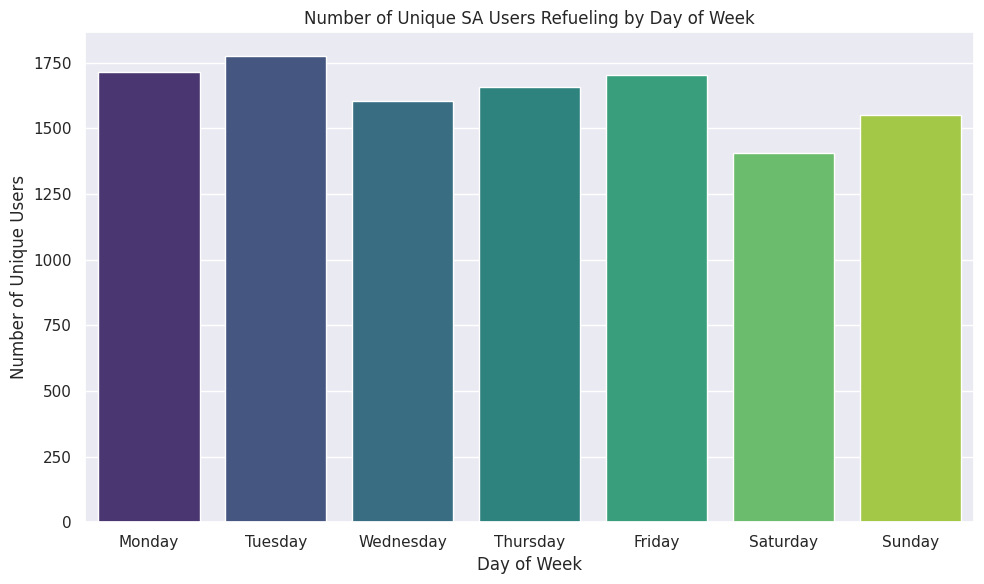

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the South African drivers dataframe
sa_df['day_of_week'] = sa_df['date_fueled_proxy'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sa_df['day_name'] = sa_df['day_of_week'].apply(lambda x: day_names[x])

# Count unique users refueling per day of week
users_per_day = sa_df.groupby('day_name')['user_id'].nunique().reindex(day_names)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=users_per_day.index, y=users_per_day.values, palette='viridis')
plt.title('Number of Unique SA Users Refueling by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Unique Users')
plt.tight_layout()
plt.show()

4. Now reduce your dataset to only the entries on the 1st Tuesday and 1st
Wednesday in SA every month.

In [86]:
import pandas as pd

# Ensure date column is datetime
sa_df['date'] = sa_df['date_fueled_proxy']

# Add day of week and day of month columns
sa_df['day_of_week'] = sa_df['date'].dt.dayofweek  # 0=Mon, 1=Tue, 2=Wed, ...
sa_df['day_of_month'] = sa_df['date'].dt.day
sa_df['year_month'] = sa_df['date'].dt.to_period('M')

# Find 1st Tuesday and 1st Wednesday for each month
first_tuesdays = sa_df[sa_df['day_of_week'] == 1].groupby('year_month')['day_of_month'].min()
first_wednesdays = sa_df[sa_df['day_of_week'] == 2].groupby('year_month')['day_of_month'].min()

# Filter for rows matching the 1st Tuesday or 1st Wednesday of each month
mask_tuesday = sa_df.apply(lambda row: row['day_of_week'] == 1 and row['day_of_month'] == first_tuesdays[row['year_month']], axis=1)
mask_wednesday = sa_df.apply(lambda row: row['day_of_week'] == 2 and row['day_of_month'] == first_wednesdays[row['year_month']], axis=1)
sa_first_tues_weds = sa_df[mask_tuesday | mask_wednesday].copy()

print(sa_first_tues_weds.sample(10))


         user_id date_fueled_proxy currency  total_spent_float  cpg_float  \
1002306  1050421        2021-11-02        R             734.18      67.46   
723546   1043876        2021-10-06        R              740.7      69.42   
702100    554590        2021-05-04        R             545.32      64.73   
564692    437574        2021-05-05        R              859.3      58.41   
710513   1096502        2021-11-02        R             809.99      66.06   
193435    601158        2018-05-01        R             325.68      53.87   
16452     954610        2021-04-06        R             761.08      57.61   
39233     147118        2022-03-01        R             699.67      76.26   
998017    277660        2015-07-01        R             583.94      48.19   
523931    455805        2016-09-07        R             462.25      47.32   

              car_make  car_model  car_year          km_driven  \
1002306  mercedes-benz       c270    2004.0      658.603726656   
723546            fo

5. For each Tuesday and Wednesday, add an indicator for whether the price
goes up or the price goes down that month.

In [87]:
# Ensure year_month is present
sa_first_tues_weds['year_month'] = sa_first_tues_weds['date'].dt.to_period('M')

# Calculate average price per month for SA
monthly_avg = sa_df.groupby('year_month')['cpl_float'].mean().sort_index()

# Calculate price change direction for each month
monthly_change = monthly_avg.diff().apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else 'same'))

# Map indicator to each row in sa_first_tues_weds
sa_first_tues_weds['price_change'] = sa_first_tues_weds['year_month'].map(monthly_change)

# Sample output
print(sa_first_tues_weds[['date', 'cpl_float', 'price_change']].sample(10))

              date          cpl_float price_change
278217  2022-04-05  21.60399044184938           up
397939  2017-01-03  12.84932862670034           up
367502  2016-10-04 11.829624504597886           up
658381  2019-02-05 13.789781133095348         down
874653  2015-01-06 12.141347526380502         down
1043308 2020-10-07 13.369747569845892         down
1142425 2018-12-04 16.159404442747938         down
1128432 2016-11-01 12.339476565649113           up
54812   2018-11-06 16.489619508195624           up
98875   2017-07-04 13.538817683355107         down


6. Do more people refuel on the first Wednesday of the month when the
prices goes down?

Number of unique users refueling on first Wednesday by price change:
price_change
down    277
up      297
Name: user_id, dtype: int64


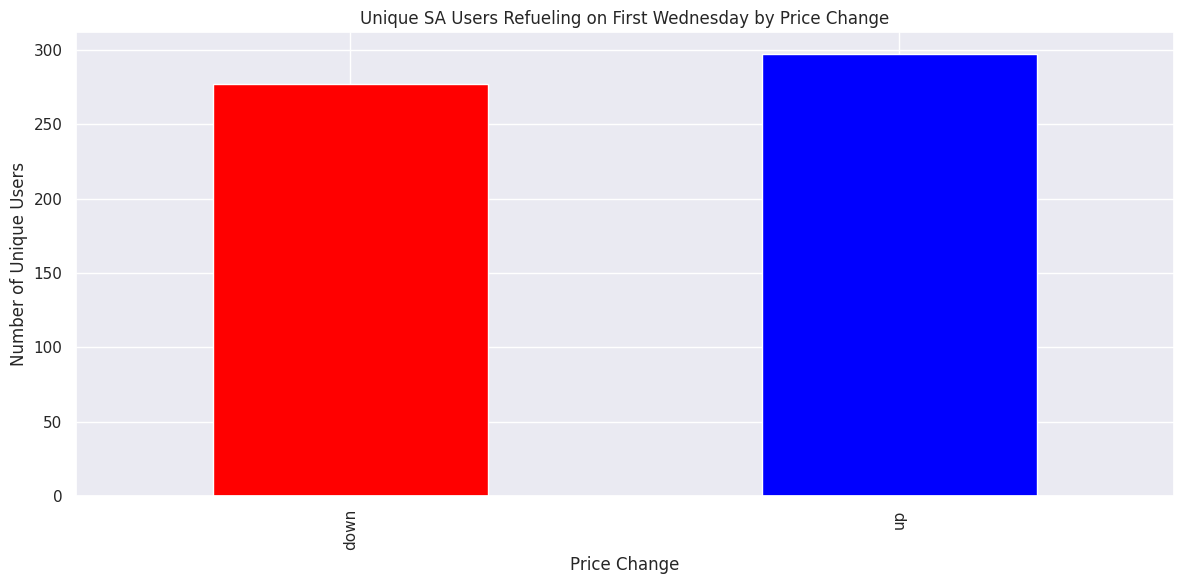

In [88]:
# Filter for first Wednesdays only
first_weds = sa_first_tues_weds[sa_first_tues_weds['day_of_week'] == 2]

# Group by price change and count unique users
weds_counts = first_weds.groupby('price_change')['user_id'].nunique()

print("Number of unique users refueling on first Wednesday by price change:")
print(weds_counts)

# Optional: visualize
import matplotlib.pyplot as plt
weds_counts.plot(kind='bar', color=['red' if x=='down' else 'blue' for x in weds_counts.index])
plt.title('Unique SA Users Refueling on First Wednesday by Price Change')
plt.xlabel('Price Change')
plt.ylabel('Number of Unique Users')
plt.tight_layout()
plt.show()

7. Do more people refuel on the first Tuesday of the month when the prices
goes up?

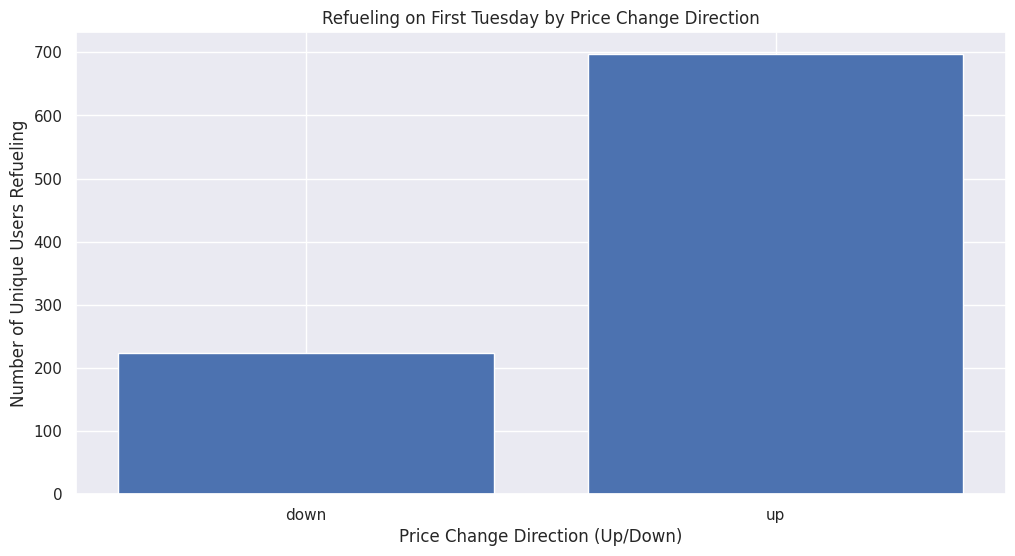

In [89]:
# Ensure 'date' is datetime
sa_df['date'] = pd.to_datetime(sa_df['date'])

# Get first Tuesday of each month
first_tuesdays = sa_df[sa_df['date'].dt.weekday == 1].copy()  # 0=Monday, 1=Tuesday
first_tuesdays['month_year'] = first_tuesdays['date'].dt.to_period('M')
first_tuesdays = first_tuesdays.sort_values('date').groupby('month_year').first().reset_index()

# Merge back to get all refueling events on first Tuesday
sa_first_tuesday = sa_df.merge(first_tuesdays[['date', 'month_year']], on=['date'], how='inner')

# Map price_change to sa_first_tuesday using monthly_change from cell 74
sa_first_tuesday['year_month'] = sa_first_tuesday['date'].dt.to_period('M')
sa_first_tuesday['price_change'] = sa_first_tuesday['year_month'].map(monthly_change)

# Count unique users by price change direction
result = sa_first_tuesday.groupby('price_change')['user_id'].nunique().reset_index()
result = result.rename(columns={'user_id': 'num_users'})

# Plot
import matplotlib.pyplot as plt
plt.bar(result['price_change'], result['num_users'])
plt.xlabel('Price Change Direction (Up/Down)')
plt.ylabel('Number of Unique Users Refueling')
plt.title('Refueling on First Tuesday by Price Change Direction')
plt.show()